In [1]:
import sys
sys.path.append('../')
import os
import warnings
warnings.filterwarnings('ignore')
from os.path import splitext

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from multiprocessing import Pool
from functools import partial
from tqdm.auto import tqdm


from utils.imageprocessing import getPoints_fromPNG, convert_PNGtoSHP
import rasterio
from shapely.geometry import Point, box
import geopandas as gpd
import cv2


In [2]:
dataset_path= '../data/tiles/formatted'

In [3]:
def load_image(filename):
    ext = splitext(filename)[1]
    if ext == '.npy':
        return Image.fromarray(np.load(filename))
    elif ext in ['.pt', '.pth']:
        return Image.fromarray(torch.load(filename).numpy())
    else:
        #return Image.open(filename)
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return Image.fromarray(img).convert('L')

In [4]:
class ImageDataset(Dataset):
    def __init__(self, dataset_path) -> None:
        files = os.listdir(dataset_path)
        self.images_path = []
        self.masks_path = []
        self.image_coords = []
        self.mask_coords = []
        
        for file in files:
            if file.split('_')[1]=='tif':
                self.images_path.append(os.path.join(dataset_path,file))
                self.masks_path.append(os.path.join(dataset_path,file.replace('tif','shp')))
                xy = splitext(file)[0].split('_')[2:4]
                self.image_coords.append((int(xy[0]),int(xy[1])))
                xy = splitext(file.replace('tif','shp'))[0].split('_')[2:4]
                self.mask_coords.append((int(xy[0]),int(xy[1])))
                
    def __len__(self):
        return len(self.images_path)
    
    @staticmethod
    def preprocess(mask_values, pil_img, scale, is_mask):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
        pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
        img = np.asarray(pil_img)
        if img.ndim == 2:
            img = img[np.newaxis, ...]
        else:
            img = img.transpose((2, 0, 1))
        #if (img > 1).any():
        #    img = img / 255.0
        img = img / 255.0
        if is_mask:
            img = img / 255.0
        return img
        
    def __getitem__(self, idx):
        #return {
        #    'image': self.images_path[idx],
        #    'mask': self.masks_path[idx]
        #}
        mask = load_image(self.images_path[idx])
        img = load_image(self.masks_path[idx])
        img = img.convert('L')
        
        assert img.size == mask.size, \
            f'Image and mask should be the same size, but are {img.size} and {mask.size}'

        self.scale = 1.0
        #self.scale = 0.2
        
        img = self.preprocess(1, img, self.scale, is_mask=False)
        mask = self.preprocess(1, mask, self.scale, is_mask=True)
        return {
            'image': torch.as_tensor(img.copy()).float().contiguous(),
            'mask': torch.as_tensor(mask.copy()).long().contiguous(),
            'image_coords': self.image_coords[idx],
            'mask_coords': self.mask_coords[idx],
        }
    
class ImageNameDataset(Dataset):
    def __init__(self, dataset_path) -> None:
        files = os.listdir(dataset_path)
        self.images_path = []
        self.masks_path = []
        for file in files:
            if file.split('_')[1]=='tif':
                self.images_path.append(os.path.join(dataset_path,file))
                self.masks_path.append(os.path.join(dataset_path,file.replace('tif','shp')))
                
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, idx):
        return {
            'image': self.images_path[idx],
            'mask': self.masks_path[idx]
        }

In [6]:
dataset = ImageDataset(dataset_path)

In [7]:
val_percent = 0.2

n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

print(len(train_set),len(val_set))


12 3


In [8]:
batch_size = 1
#num_workers = os.cpu_count() - not working . . .

loader_args = dict(batch_size=batch_size, pin_memory=True)#, num_workers=os.cpu_count(), pin_memory=True)
train_loader = DataLoader(train_set, shuffle=False, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, **loader_args)

In [9]:
print('train_set:')
for batch in train_loader:
    #print(batch['image'].shape)
    #print(batch['mask'].shape)
    images, true_masks = batch['image'], batch['mask']
    img_coords, mask_coords = batch['image_coords'],batch['mask_coords']
    print(f"""{images.shape},{true_masks.shape}
            {img_coords}, {mask_coords}
          """)
    #print(images.max().item())
    #print(true_masks.max().item())
    
print('val_set:')
for batch in val_loader:
    print(batch['image'].shape)
    print(batch['mask'].shape)
    images, true_masks = batch['image'], batch['mask']
    img_coords, mask_coords = batch['image_coords'],batch['mask_coords']
    


train_set:
torch.Size([1, 1, 250, 250]),torch.Size([1, 1, 250, 250])
            [tensor([1]), tensor([4])], [tensor([1]), tensor([4])]
          
torch.Size([1, 1, 250, 250]),torch.Size([1, 1, 250, 250])
            [tensor([0]), tensor([1])], [tensor([0]), tensor([1])]
          
torch.Size([1, 1, 250, 250]),torch.Size([1, 1, 250, 250])
            [tensor([0]), tensor([3])], [tensor([0]), tensor([3])]
          
torch.Size([1, 1, 250, 250]),torch.Size([1, 1, 250, 250])
            [tensor([2]), tensor([1])], [tensor([2]), tensor([1])]
          
torch.Size([1, 1, 250, 250]),torch.Size([1, 1, 250, 250])
            [tensor([1]), tensor([2])], [tensor([1]), tensor([2])]
          
torch.Size([1, 1, 250, 250]),torch.Size([1, 1, 250, 250])
            [tensor([0]), tensor([2])], [tensor([0]), tensor([2])]
          
torch.Size([1, 1, 250, 250]),torch.Size([1, 1, 250, 250])
            [tensor([1]), tensor([3])], [tensor([1]), tensor([3])]
          
torch.Size([1, 1, 250, 250]),torch.Si

In [10]:
from src.unet_model import UNet
from utils.scores import dice_loss
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from src.evaluate import evaluate
from pathlib import Path

model = UNet(n_channels=1, n_classes=1)
weight_decay= 1e-8
learning_rate= 1e-10
amp = False
momentum = 0.999
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gradient_clipping: float = 1.0
save_checkpoint = True
dir_checkpoint = '../model/checkpoints'

In [23]:
optimizer = optim.RMSprop(model.parameters(),lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
#optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)
grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()
global_step = 0

In [24]:
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filename='../logs/training.log',
                    filemode='w')


In [25]:
logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images, true_masks = batch['image'], batch['mask']

                assert images.shape[1] == model.n_channels, \
                    f'Network has been defined with {model.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                true_masks = true_masks.to(device=device, dtype=torch.long)
                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    
                    if model.n_classes == 1:
                        loss = criterion(masks_pred.squeeze(1), true_masks.squeeze(1).float())
                        loss += dice_loss(F.sigmoid(masks_pred.squeeze(1)), true_masks.squeeze(1).float(), multiclass=False)

                    else:
                        loss = criterion(masks_pred, true_masks)
                        loss += dice_loss(
                            F.softmax(masks_pred, dim=1).float(),
                            F.one_hot(true_masks, model.n_classes).permute(0, 3, 1, 2).float(),
                            multiclass=True
                        )

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        
                        val_score = evaluate(model, val_loader, device, amp)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        
        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            state_dict = model.state_dict()
            #state_dict['mask_values'] = dataset.mask_values
            torch.save(state_dict, str(dir_checkpoint +'/'+ f'checkpoint_epoch{epoch}.pth'))
            logging.info(f'Checkpoint {epoch} saved!')


epoch 10/10: 100%|██████████| 12/12 [01:03<00:00,  5.29s/img, loss (batch)=1.87]


In [14]:
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.1):
    net.eval()
    img = torch.from_numpy(ImageDataset.preprocess(None, full_img, scale_factor, is_mask=False))
    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img).cpu()
        output = F.interpolate(output, (full_img.size[1], full_img.size[0]), mode='bilinear')
        if net.n_classes > 1:
            mask = output.argmax(dim=1)
        else:
            mask = torch.sigmoid(output) > out_threshold

    return mask[0].long().squeeze().numpy()
    #return mask[0].long().numpy()

In [11]:
net = UNet(n_channels=1, n_classes=1)
state_dict = torch.load('../model/checkpoints/checkpoint_epoch10.pth', map_location=device)
net.load_state_dict(state_dict)

<All keys matched successfully>

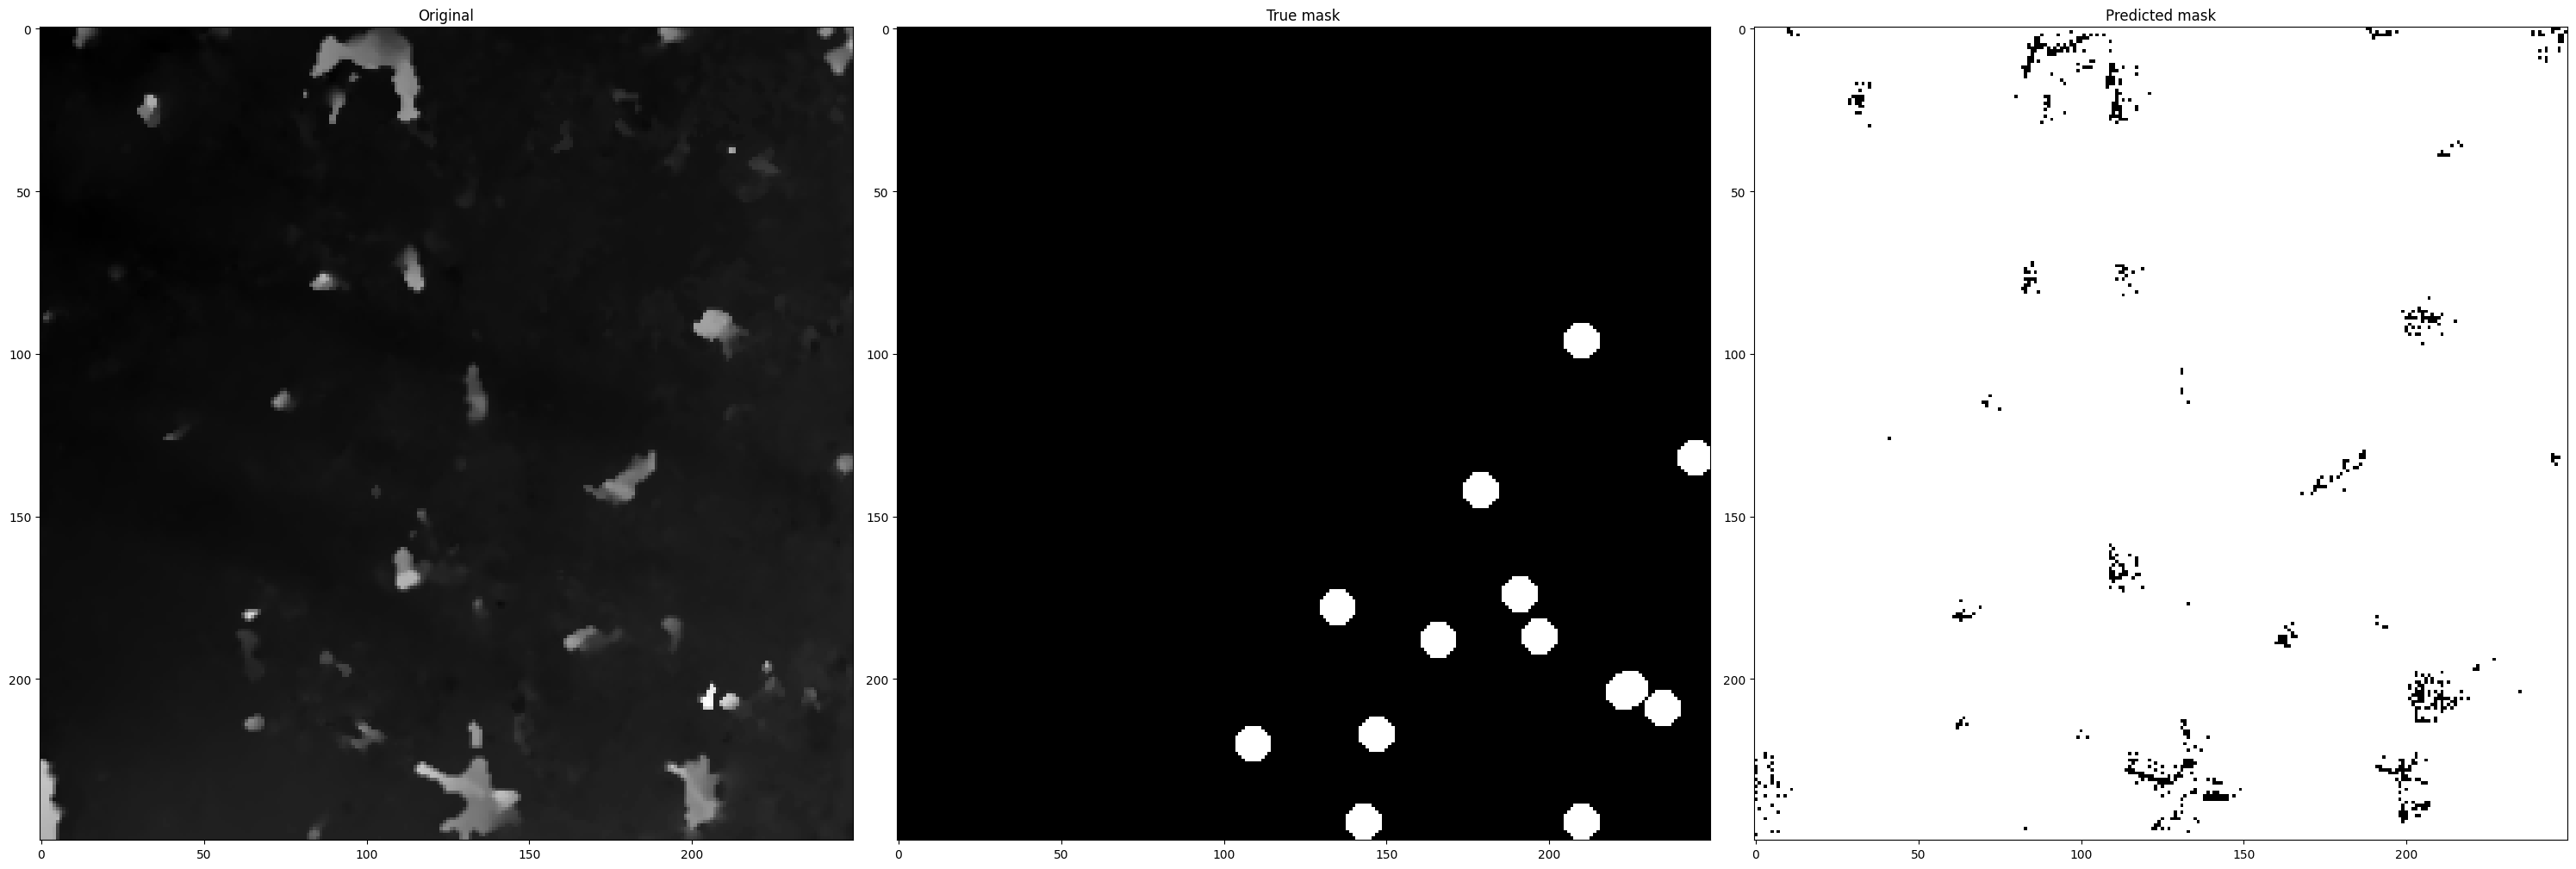

In [170]:
img = cv2.imread('../data/tiles/formatted/tile_tif_0_0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img).convert('L')
pred = predict_img(net = net,
                    full_img=img,
                    scale_factor=1,
                    out_threshold=0.4,
                    device=device)

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(load_image('../data/tiles/formatted/tile_tif_0_0.png'),cmap='grey')
plt.title('Original')

plt.subplot(1, 3, 2)  # 1 row, 2 columns, 2nd subplot
plt.imshow(load_image('../data/tiles/formatted/tile_shp_0_0.png'),cmap='grey')
plt.title('True mask')

plt.subplot(1, 3, 3)  # 1 row, 2 columns, 2nd subplot
plt.imshow(pred,cmap='grey')
plt.title('Predicted mask')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

mask_pil = Image.fromarray((pred * 255).astype(np.uint8))
#mask_pil.save('../results/firstpred_0_0.png')

In [60]:

file = 'tile_tif_0_0.png'
#img = Image.open(os.path.join('../data/tiles/formatted',file)).convert('L')

img = cv2.imread(os.path.join('../data/tiles/formatted',file))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img).convert('L')
#img = img.point(lambda p: p > threshold and 255)
#print(np.array(img))
#plt.imshow(img)
#plt.axis('off')
#plt.show()
img.show()

In [61]:
def prediction(unet,folder, out_folder):
    threshold = 254
    files = os.listdir(folder)
    for file in files:
        if file.split('_')[1]=='tif':
            print(file)
            #img = Image.open(os.path.join(folder,file)).convert('L')
            #img = img.point(lambda p: p > threshold and 255)
            img = cv2.imread(os.path.join(folder,file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(img).convert('L')
            #img.show()
            pred = predict_img(net = unet,
                    full_img=img,
                    scale_factor=1,
                    out_threshold=0.8,
                    device=device)
            mask = Image.fromarray((pred * 255).astype(np.uint8))
            tile, type, row, col = splitext(file)[0].split('_')
            mask_filename = f'pred_{tile}_png_{row}_{col}.png'
            mask.save(os.path.join(out_folder,mask_filename))

In [12]:
def plot_prediction(unet,folder, out_folder, out_threshold = 0.8):
    files = os.listdir(folder)
    for file in files:
        if file.split('_')[1]=='tif':
            print(file)
            #img = cv2.imread(os.path.join(folder,file))
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #img = Image.fromarray(img).convert('L')
            img = load_image(os.path.join(folder,file))
            pred = predict_img(net = unet,
                    full_img=img,
                    scale_factor=1,
                    out_threshold=out_threshold,
                    device=device)
            plt.figure(figsize=(30, 10))
            plt.subplot(1, 3, 1)
            plt.imshow(load_image(os.path.join(folder,file)),cmap='grey')
            plt.title('Original')
            plt.subplot(1, 3, 2)
            plt.imshow(load_image(os.path.join(folder,file.replace('_tif_','_shp_'))),cmap='grey')
            plt.title('True mask')
            plt.subplot(1, 3, 3)
            plt.imshow(pred,cmap='grey')
            plt.title('Predicted mask')
            plt.tight_layout()

            plt.show()
            

In [62]:
prediction(net,
           '../data/tiles/formatted',
           '../results')

tile_tif_0_2.png
tile_tif_2_0.png
tile_tif_2_1.png
tile_tif_0_3.png
tile_tif_0_1.png
tile_tif_2_3.png
tile_tif_2_2.png
tile_tif_0_0.png
tile_tif_0_4.png
tile_tif_2_4.png
tile_tif_1_1.png
tile_tif_1_0.png
tile_tif_1_2.png
tile_tif_1_3.png
tile_tif_1_4.png


tile_tif_0_2.png


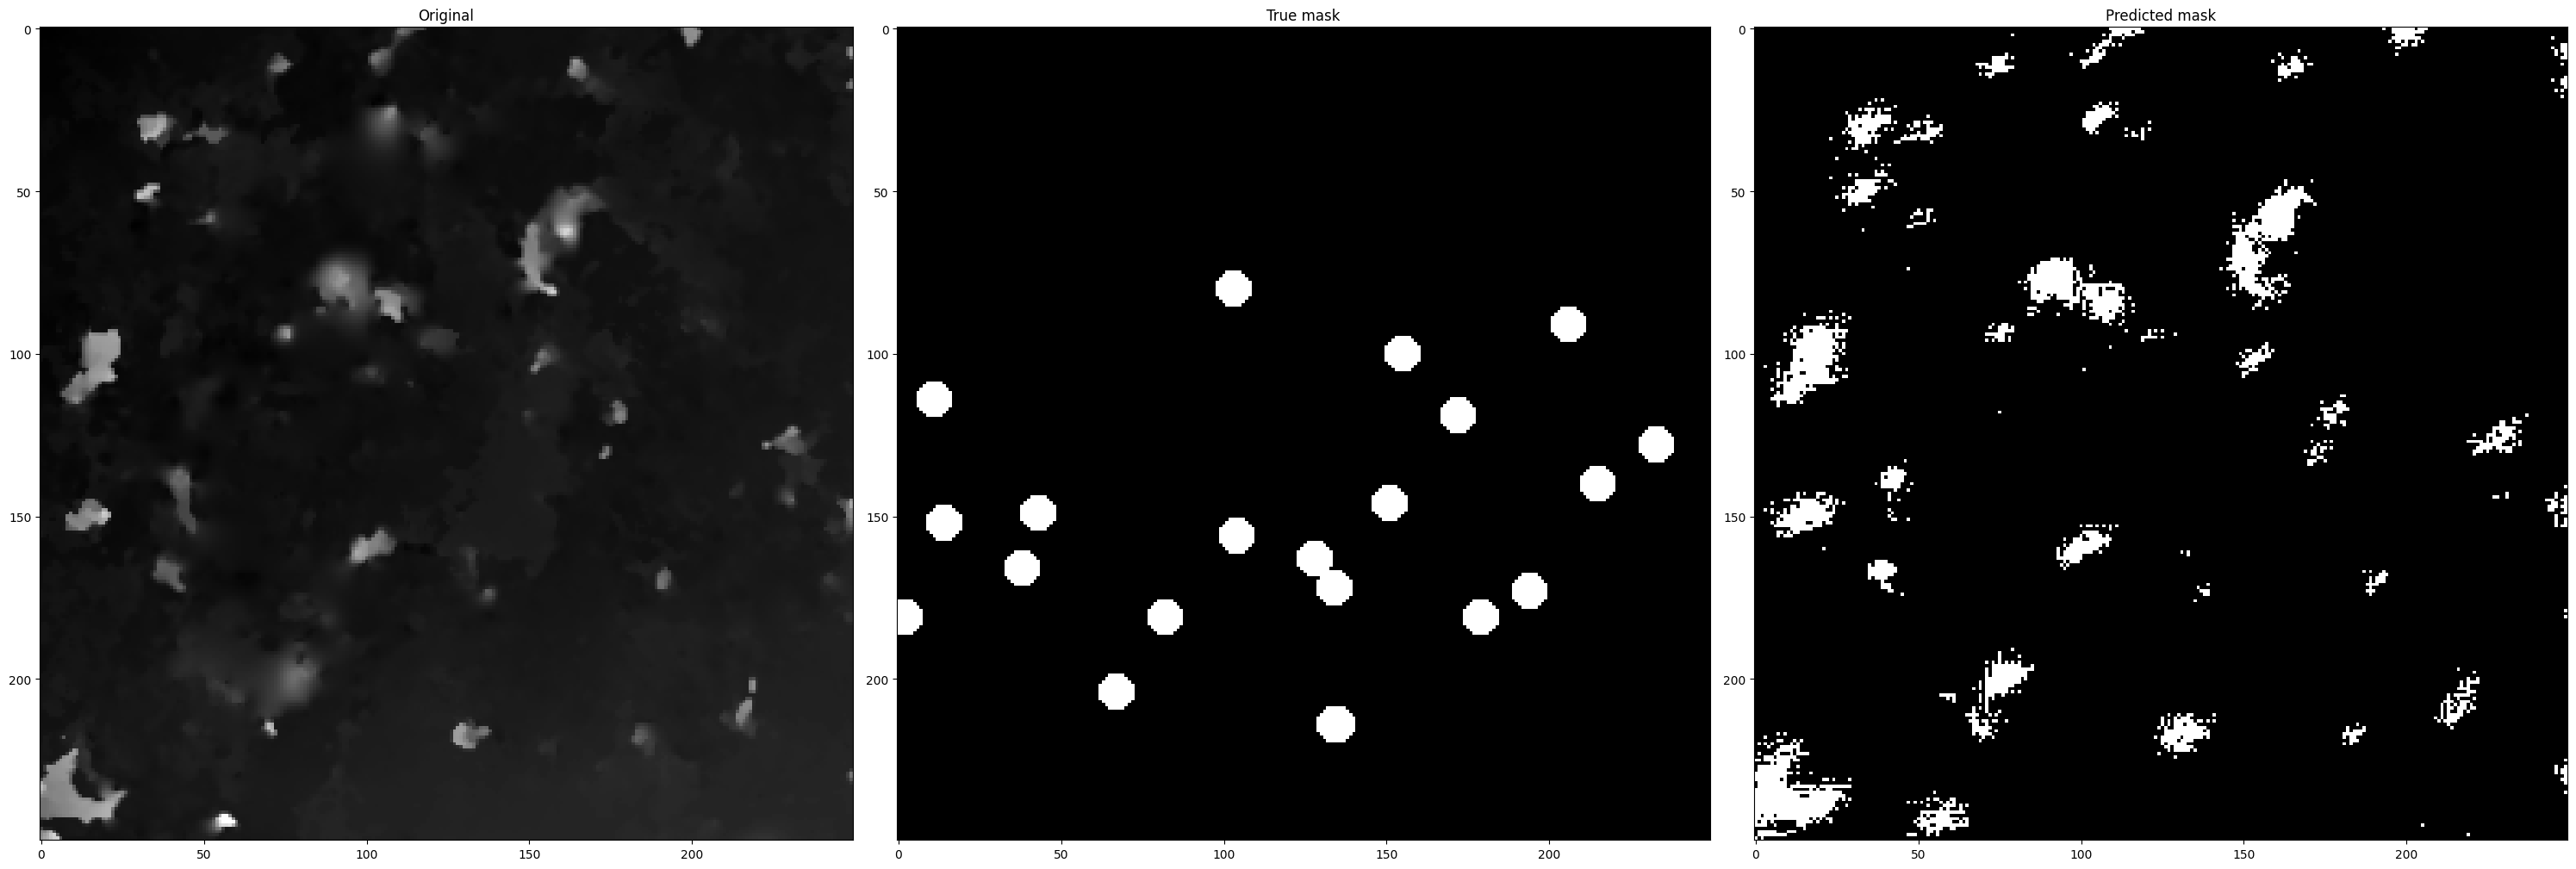

tile_tif_2_0.png


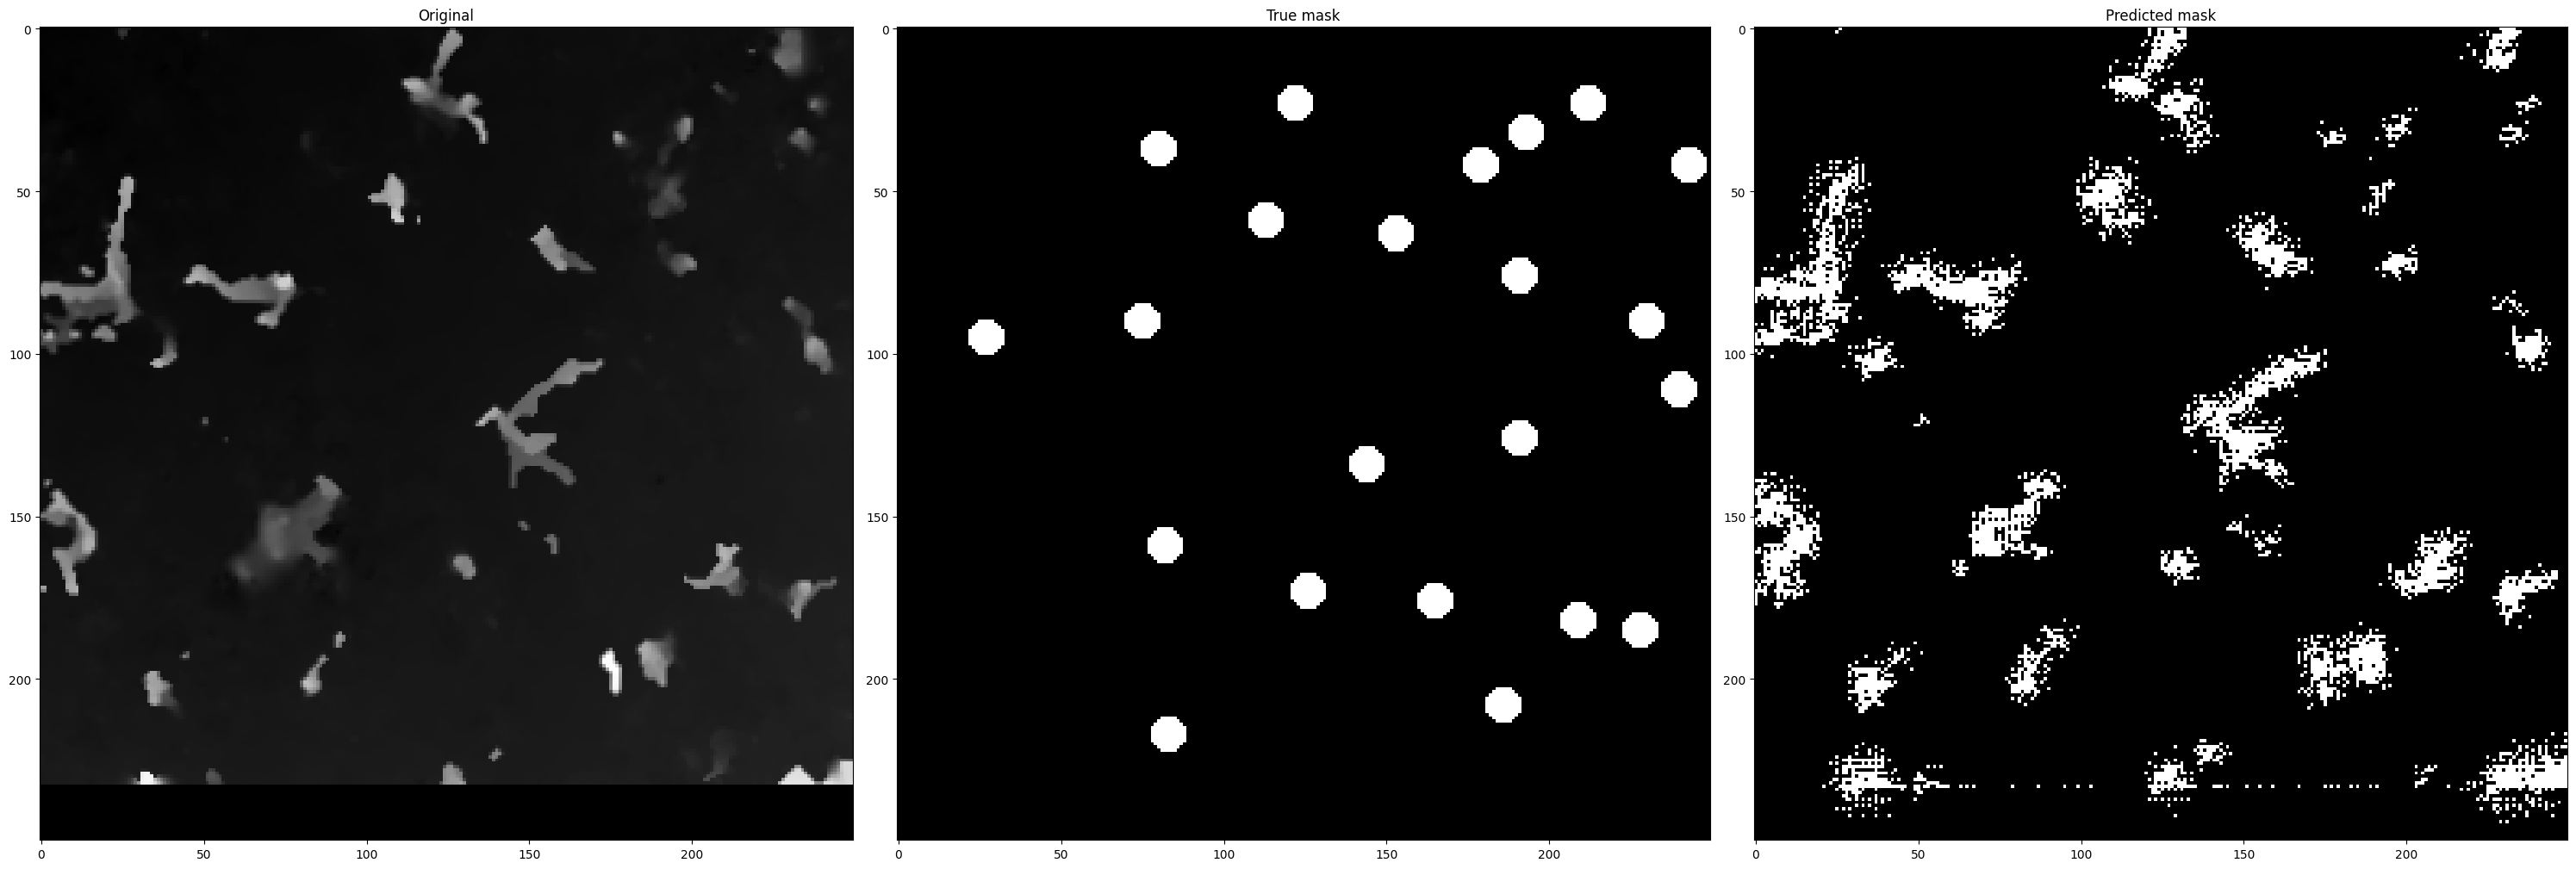

tile_tif_2_1.png


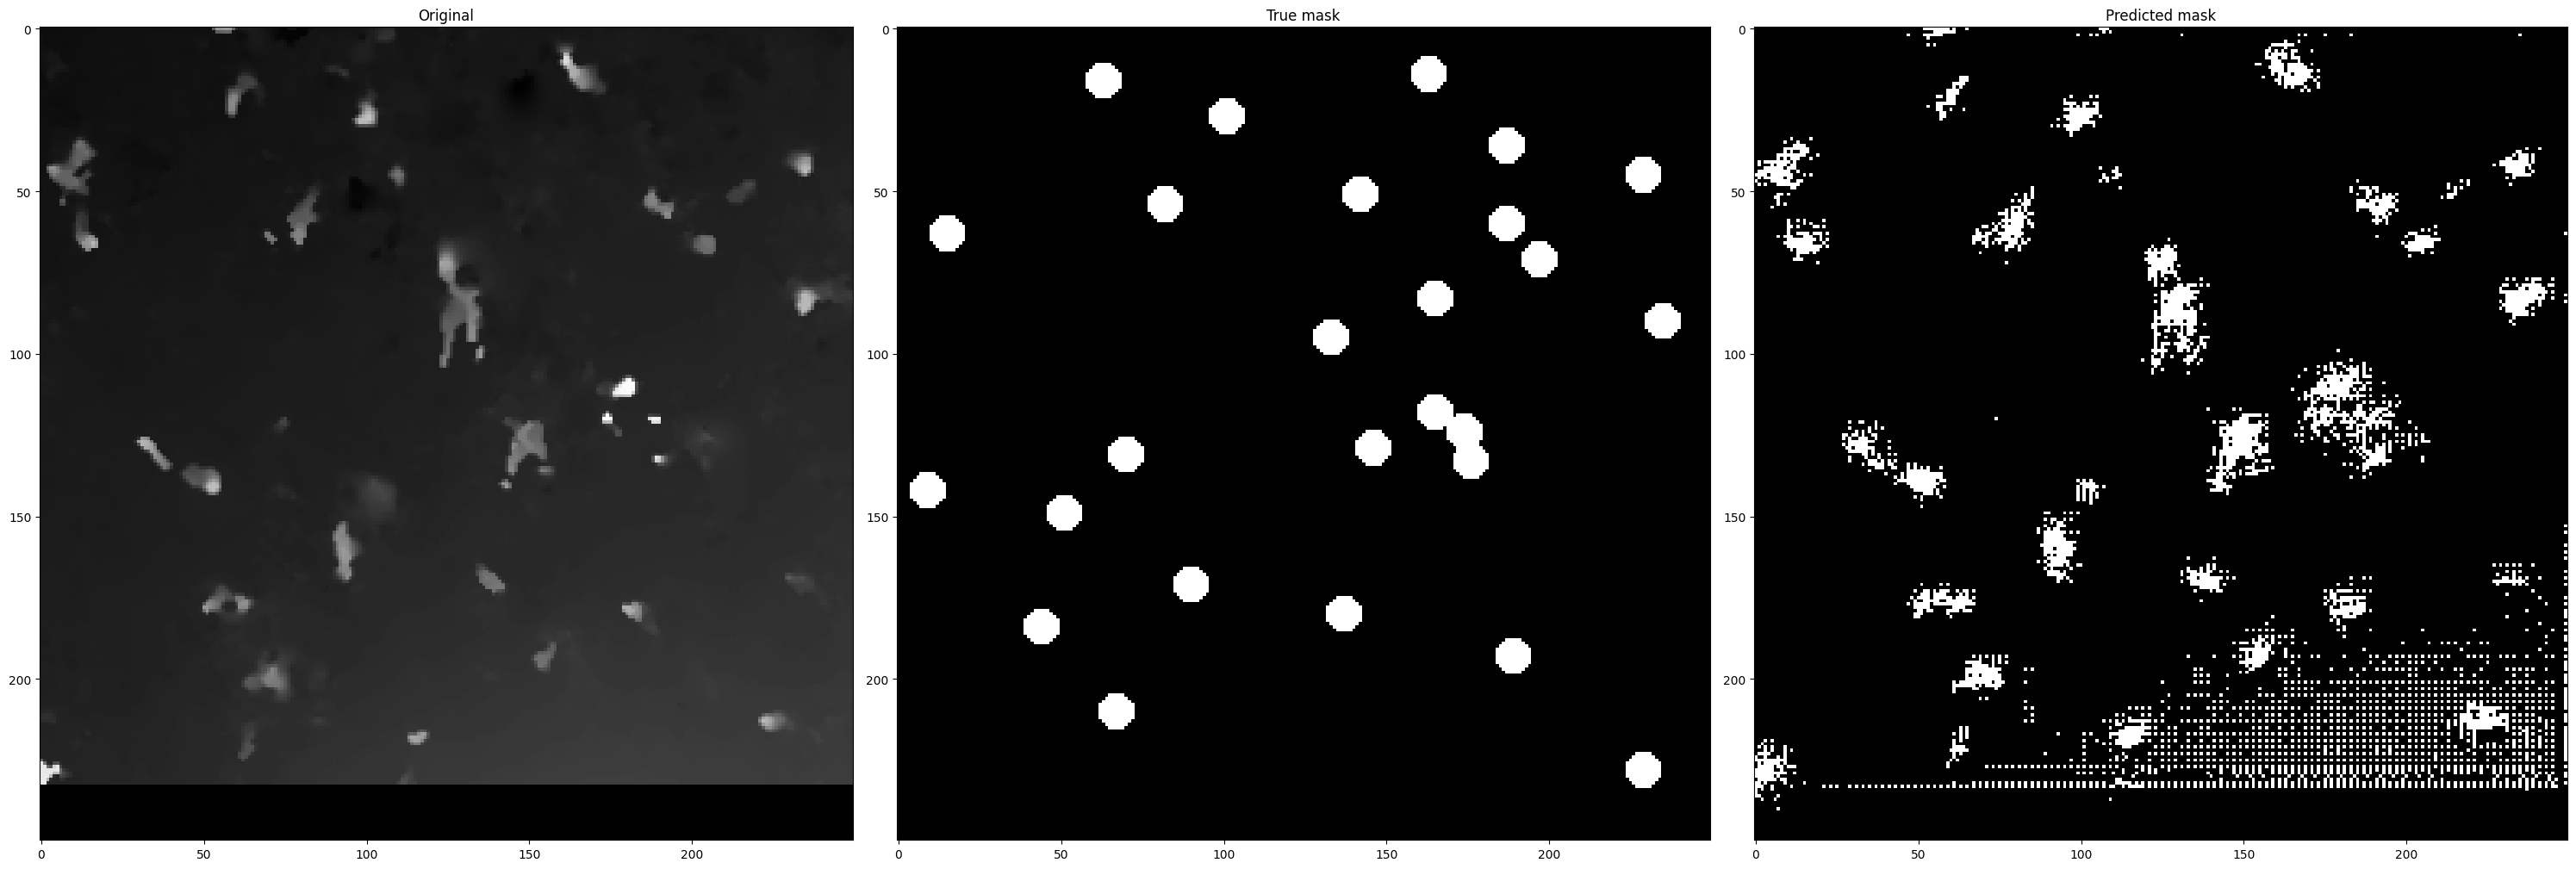

tile_tif_0_3.png


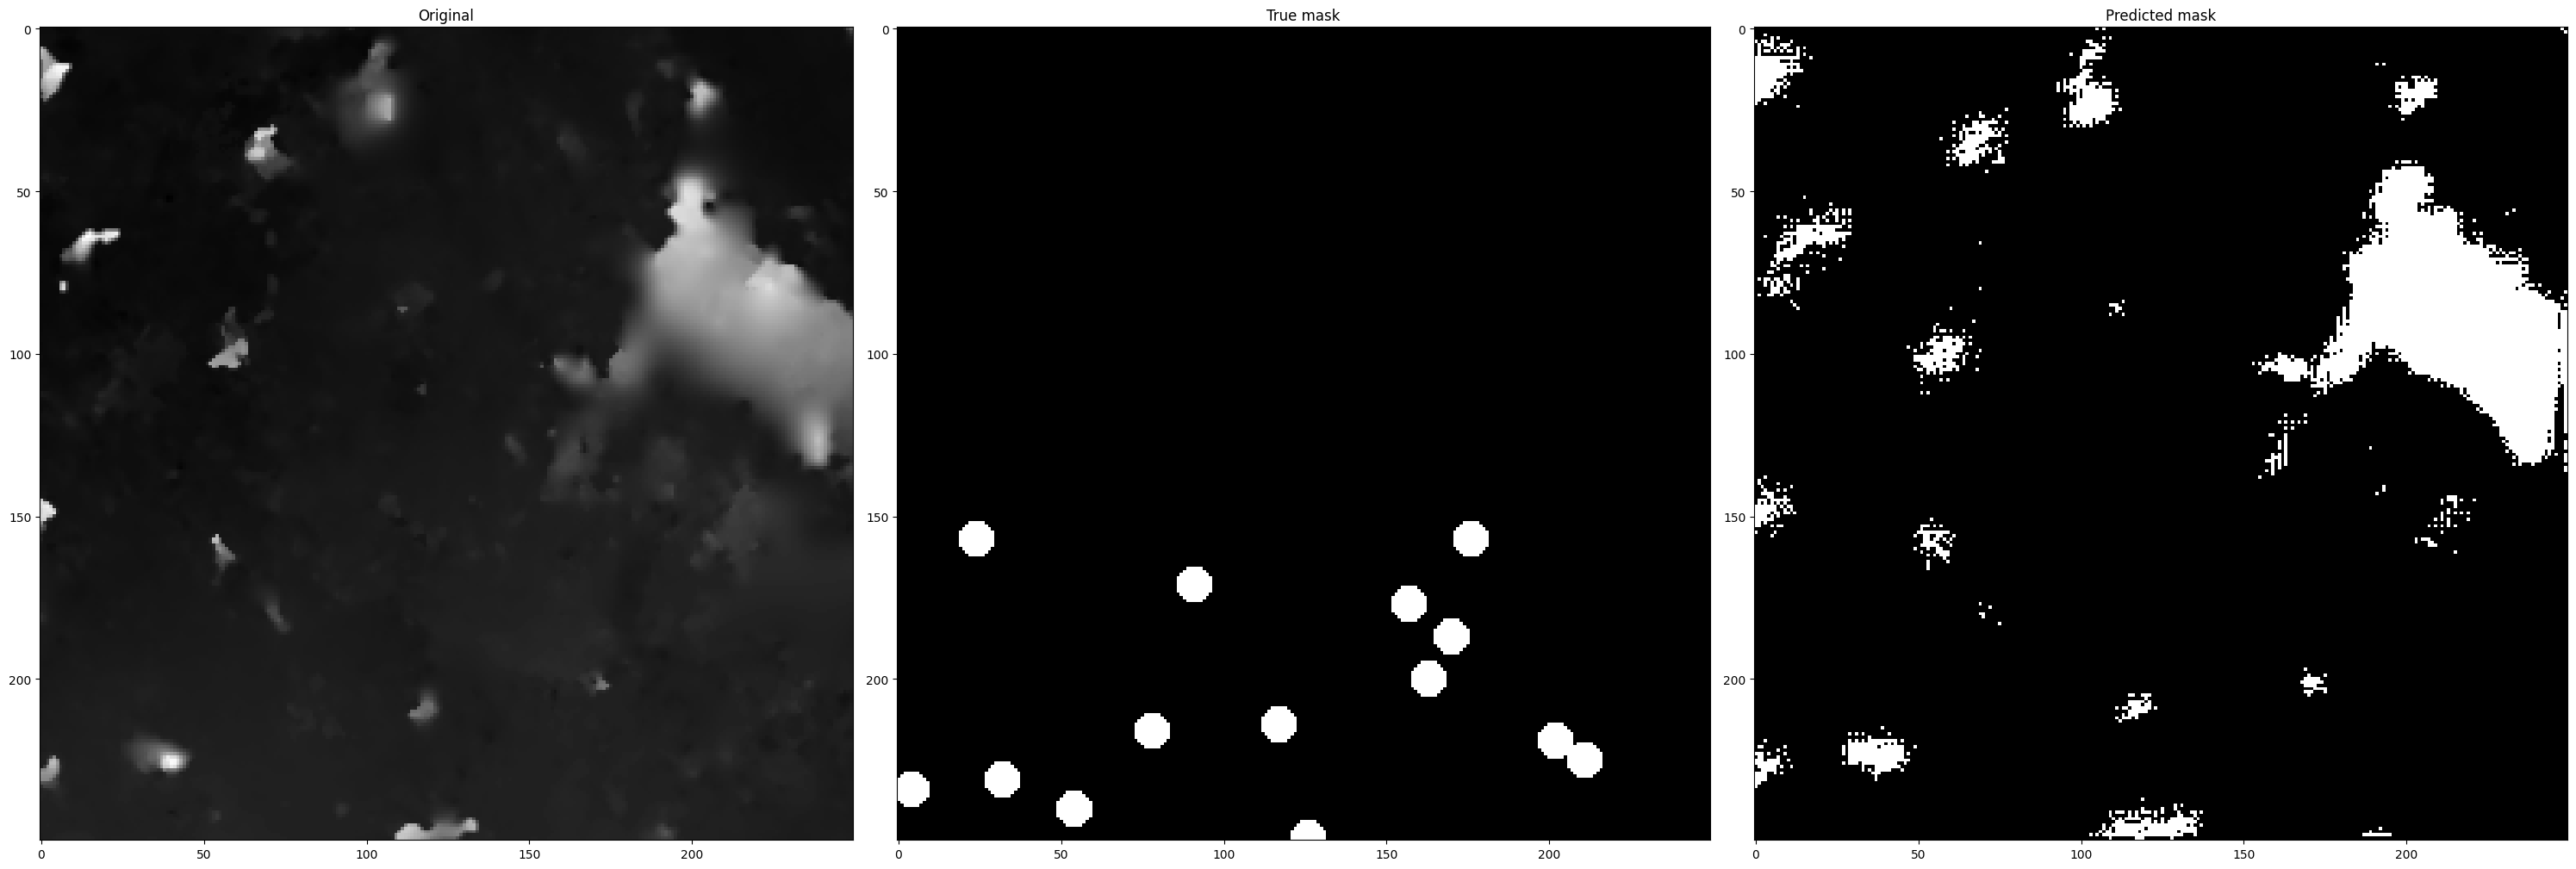

tile_tif_0_1.png


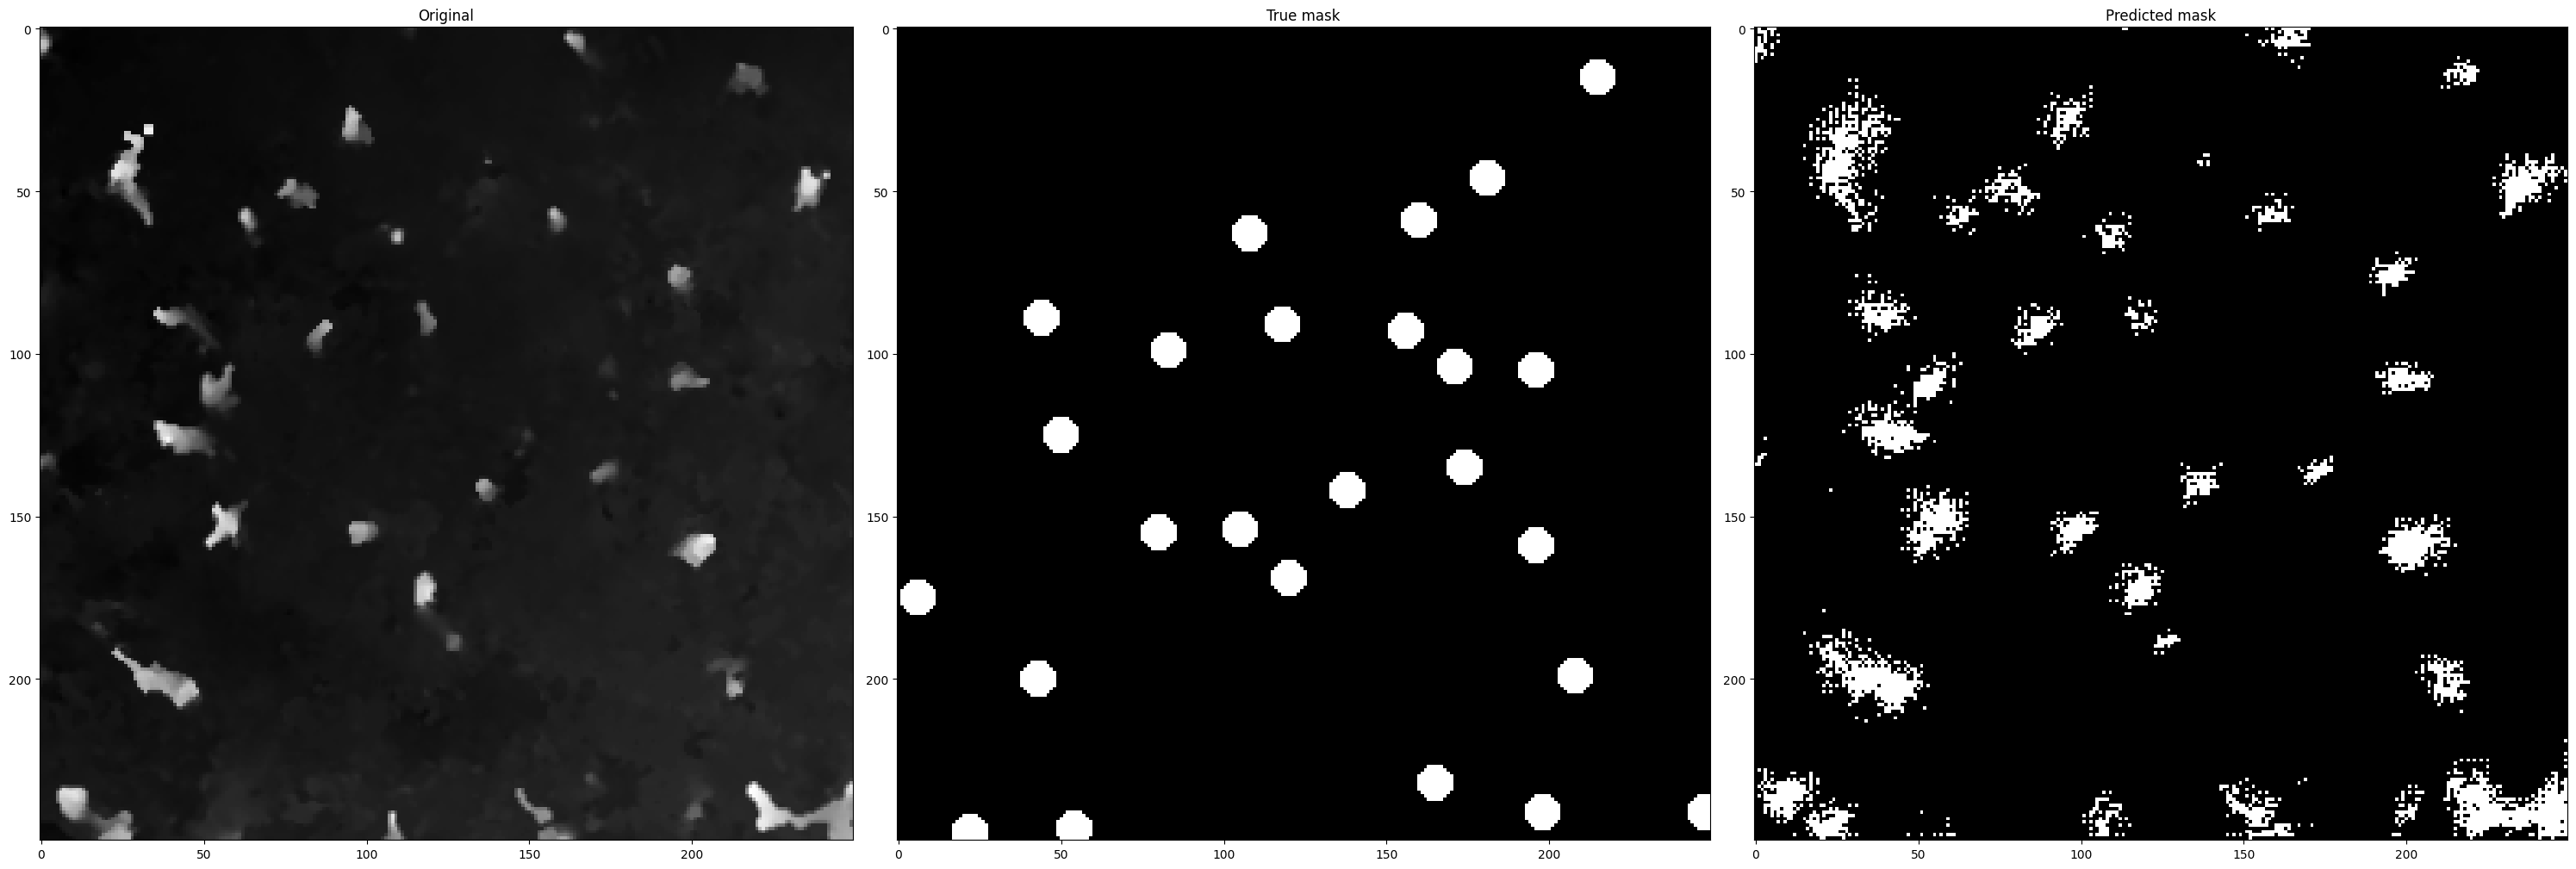

tile_tif_2_3.png


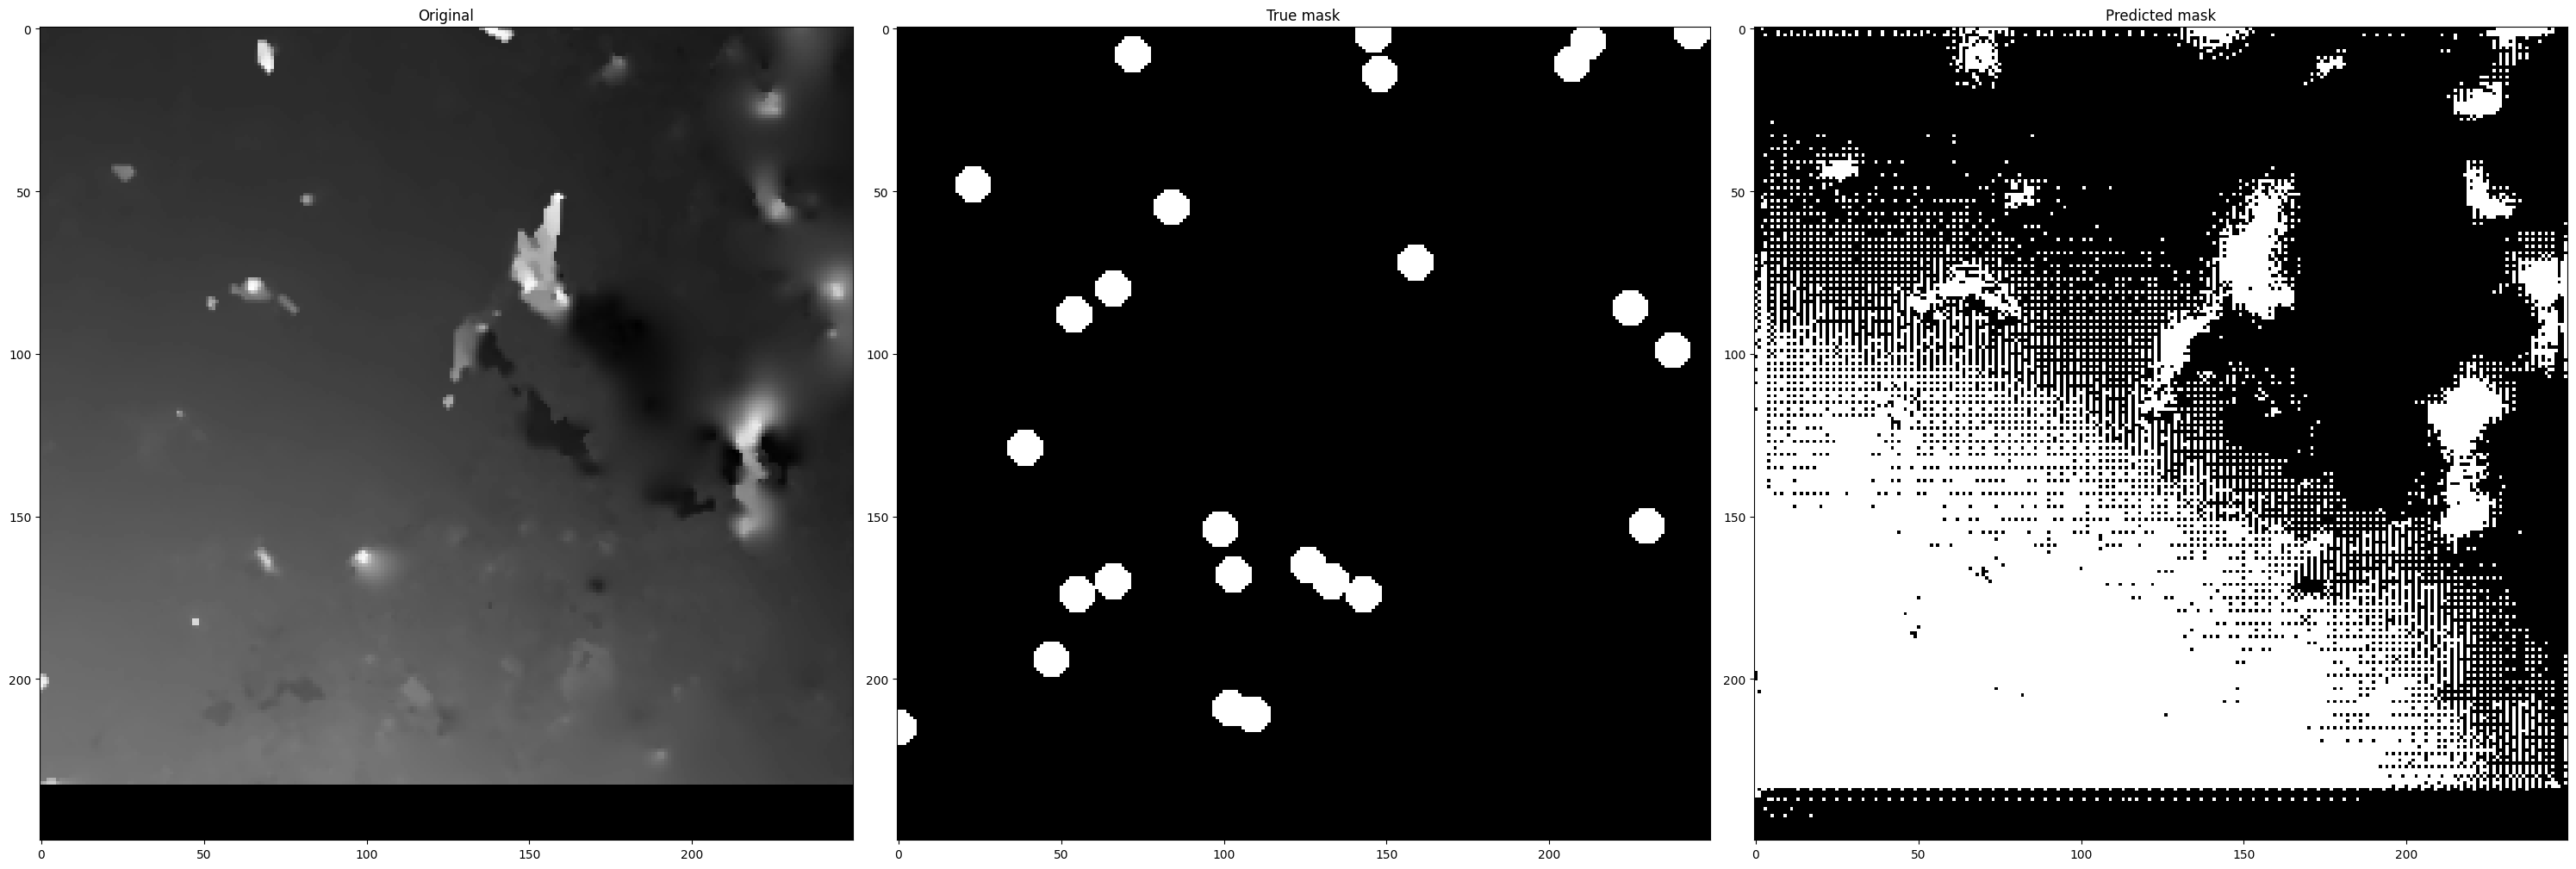

tile_tif_2_2.png


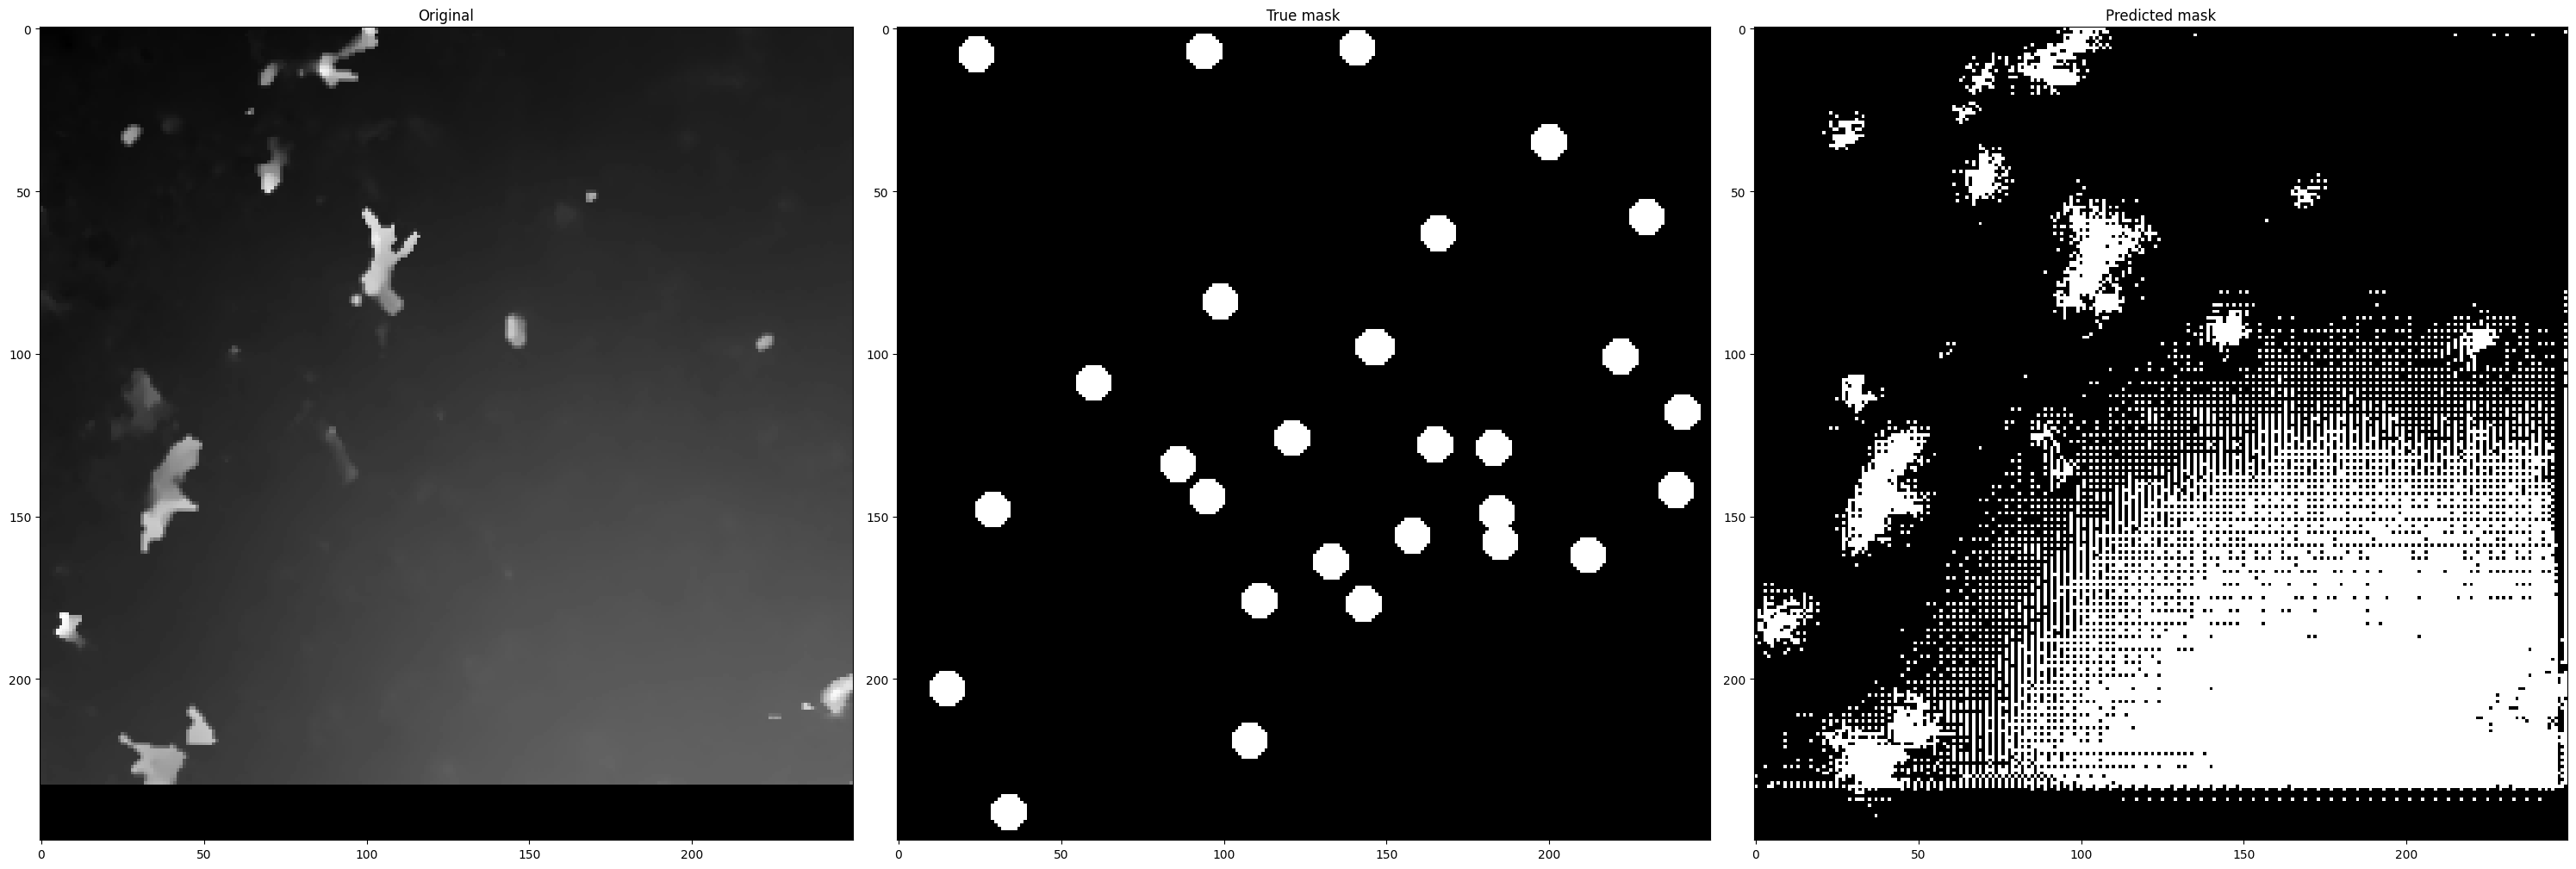

tile_tif_0_0.png


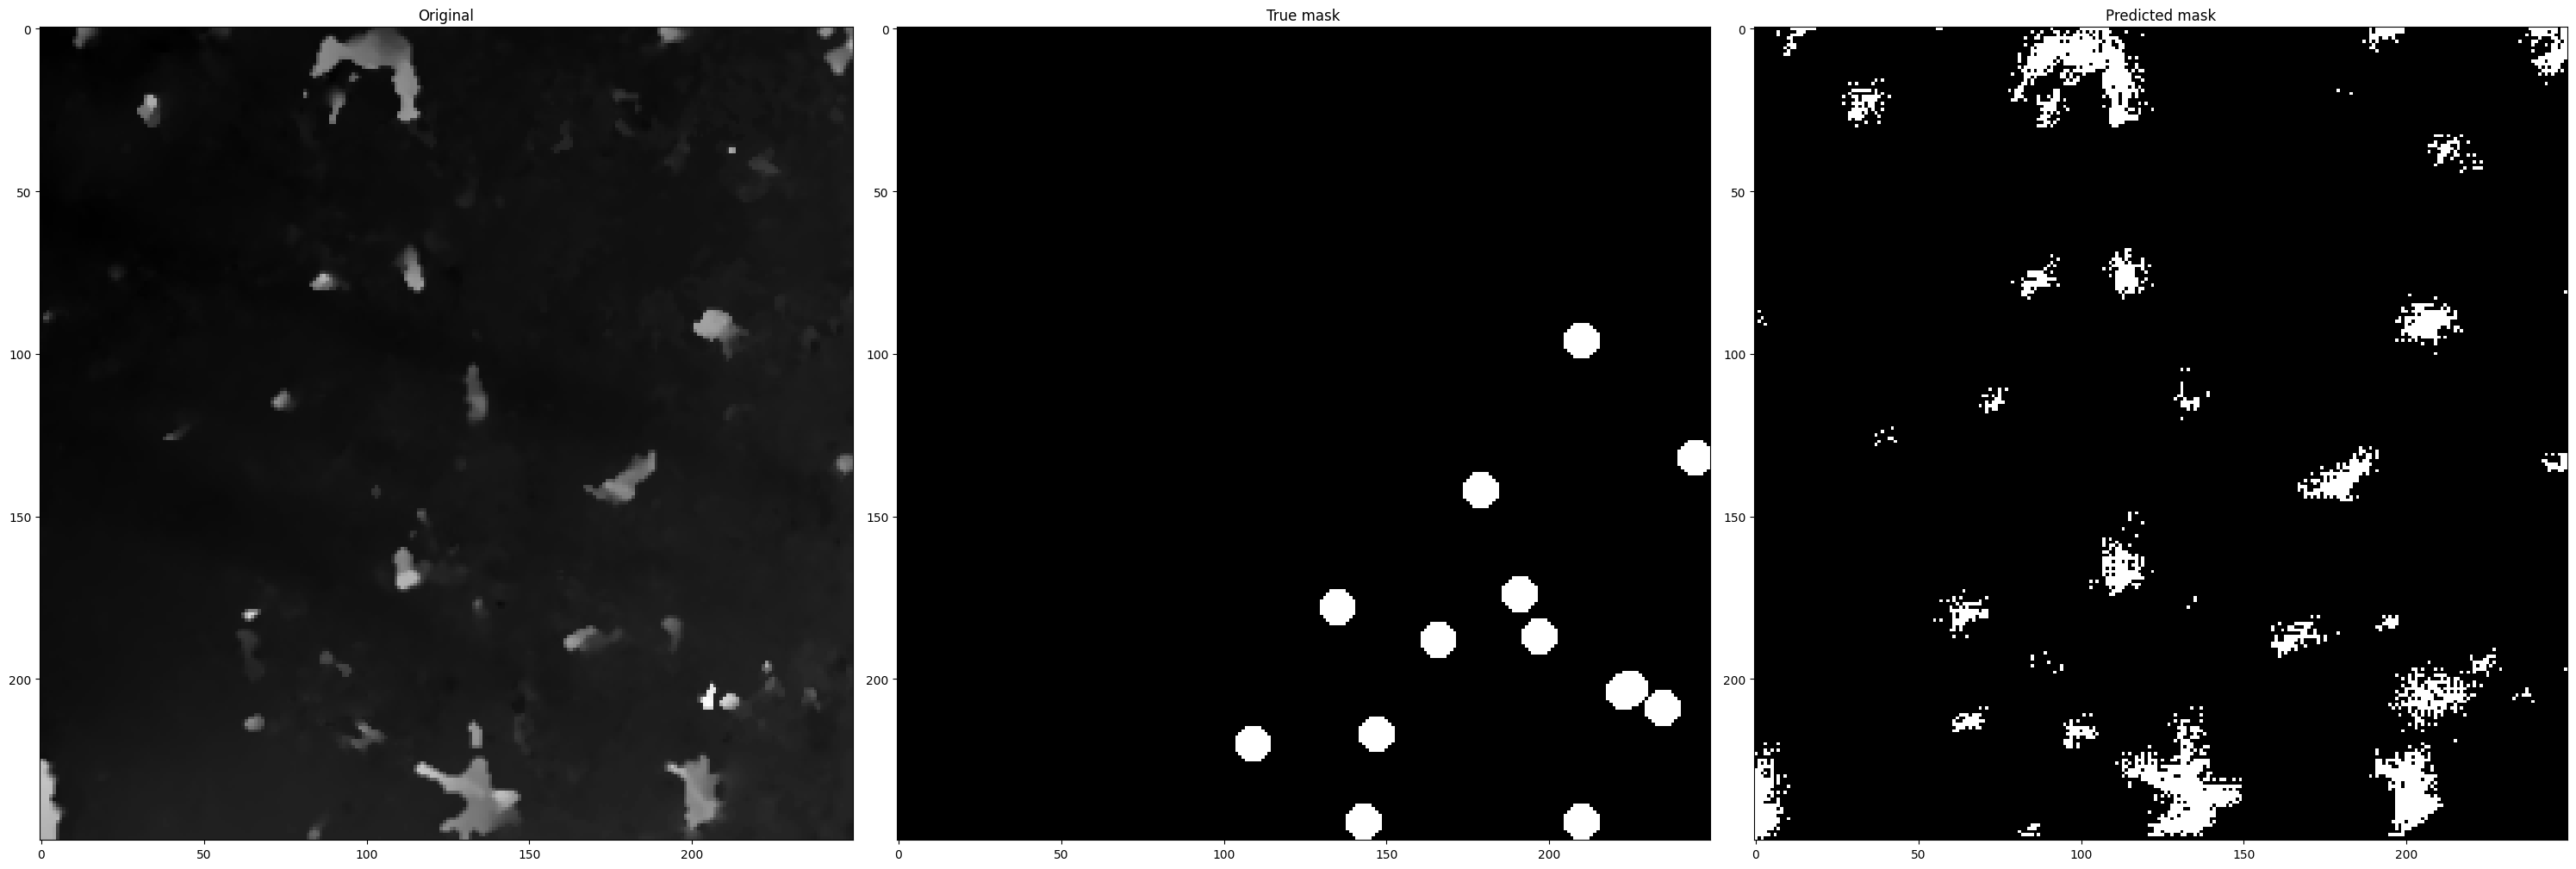

tile_tif_0_4.png


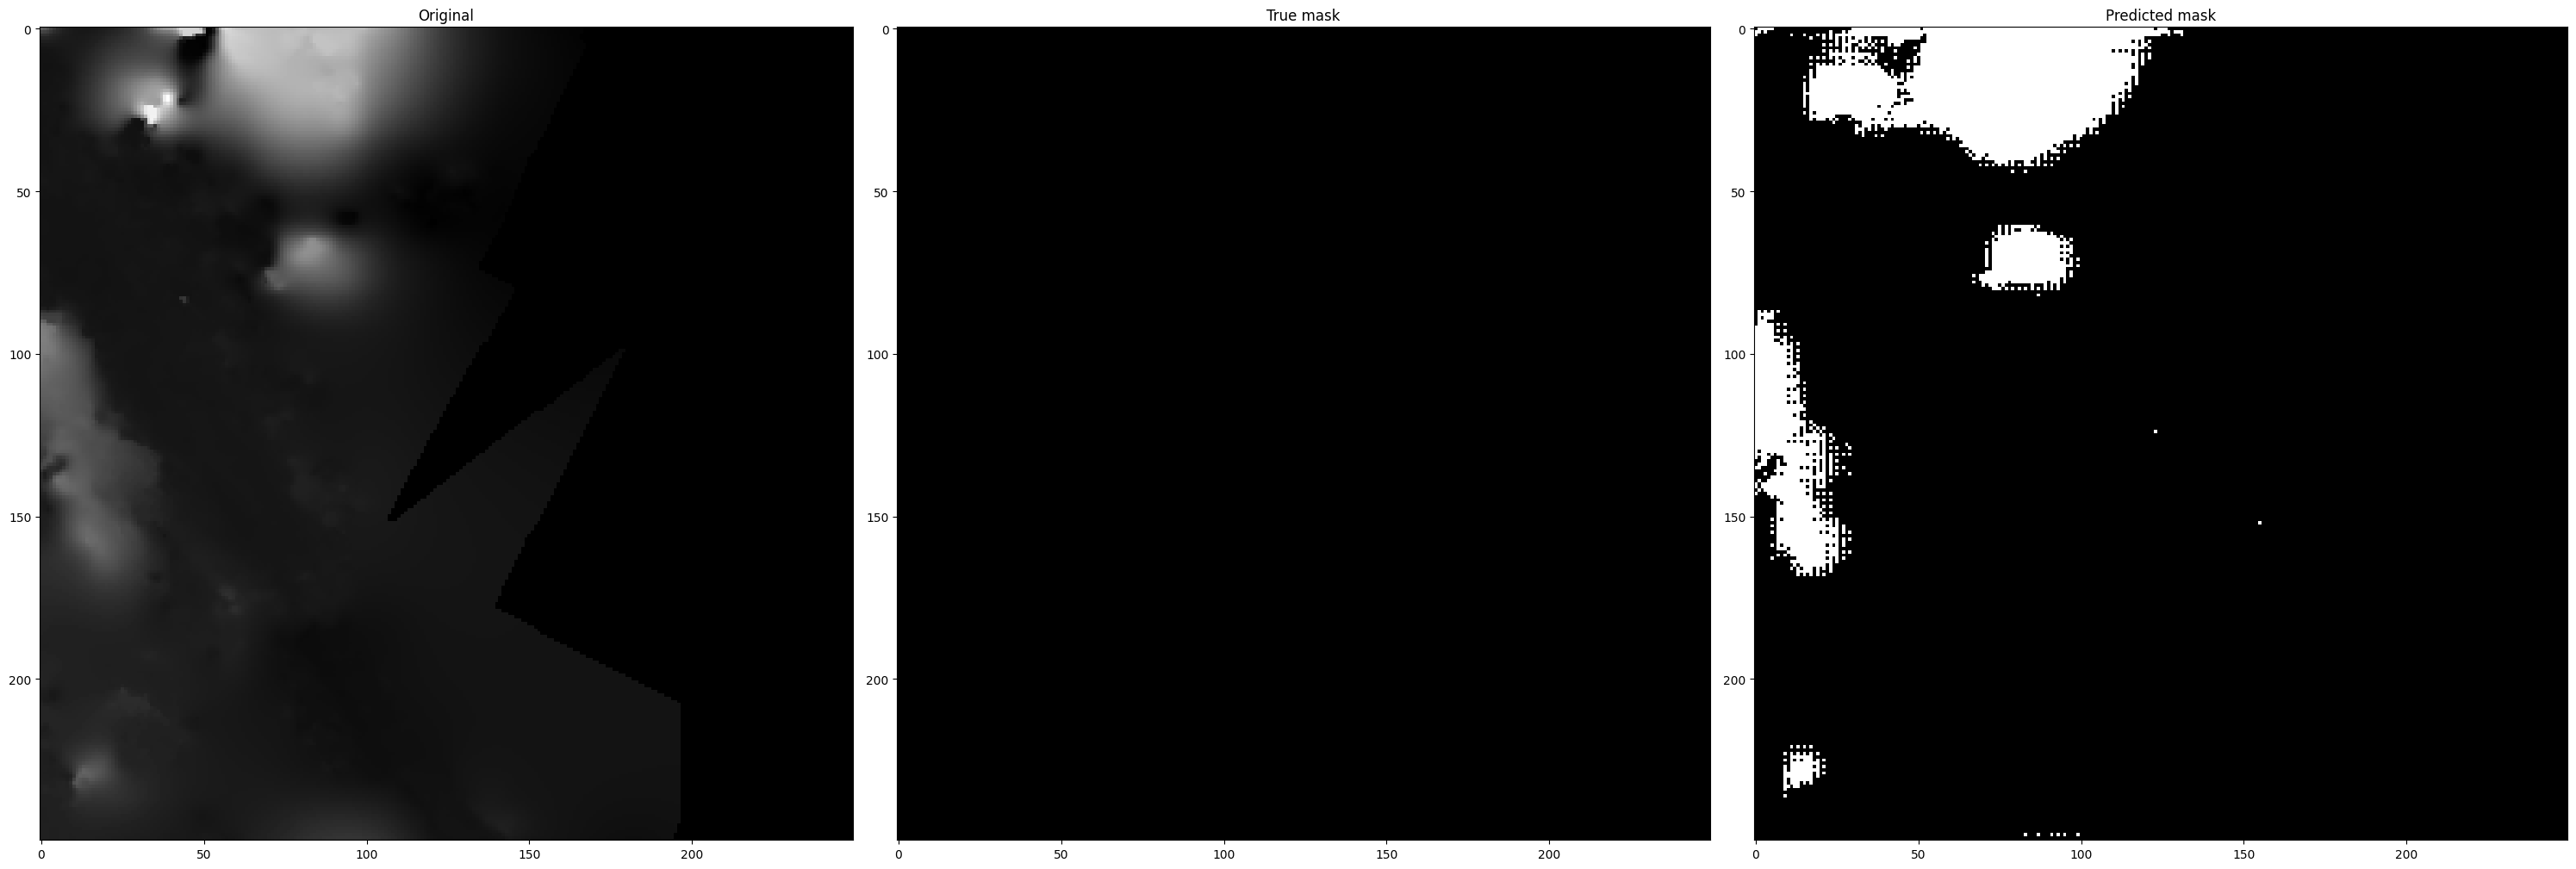

tile_tif_2_4.png


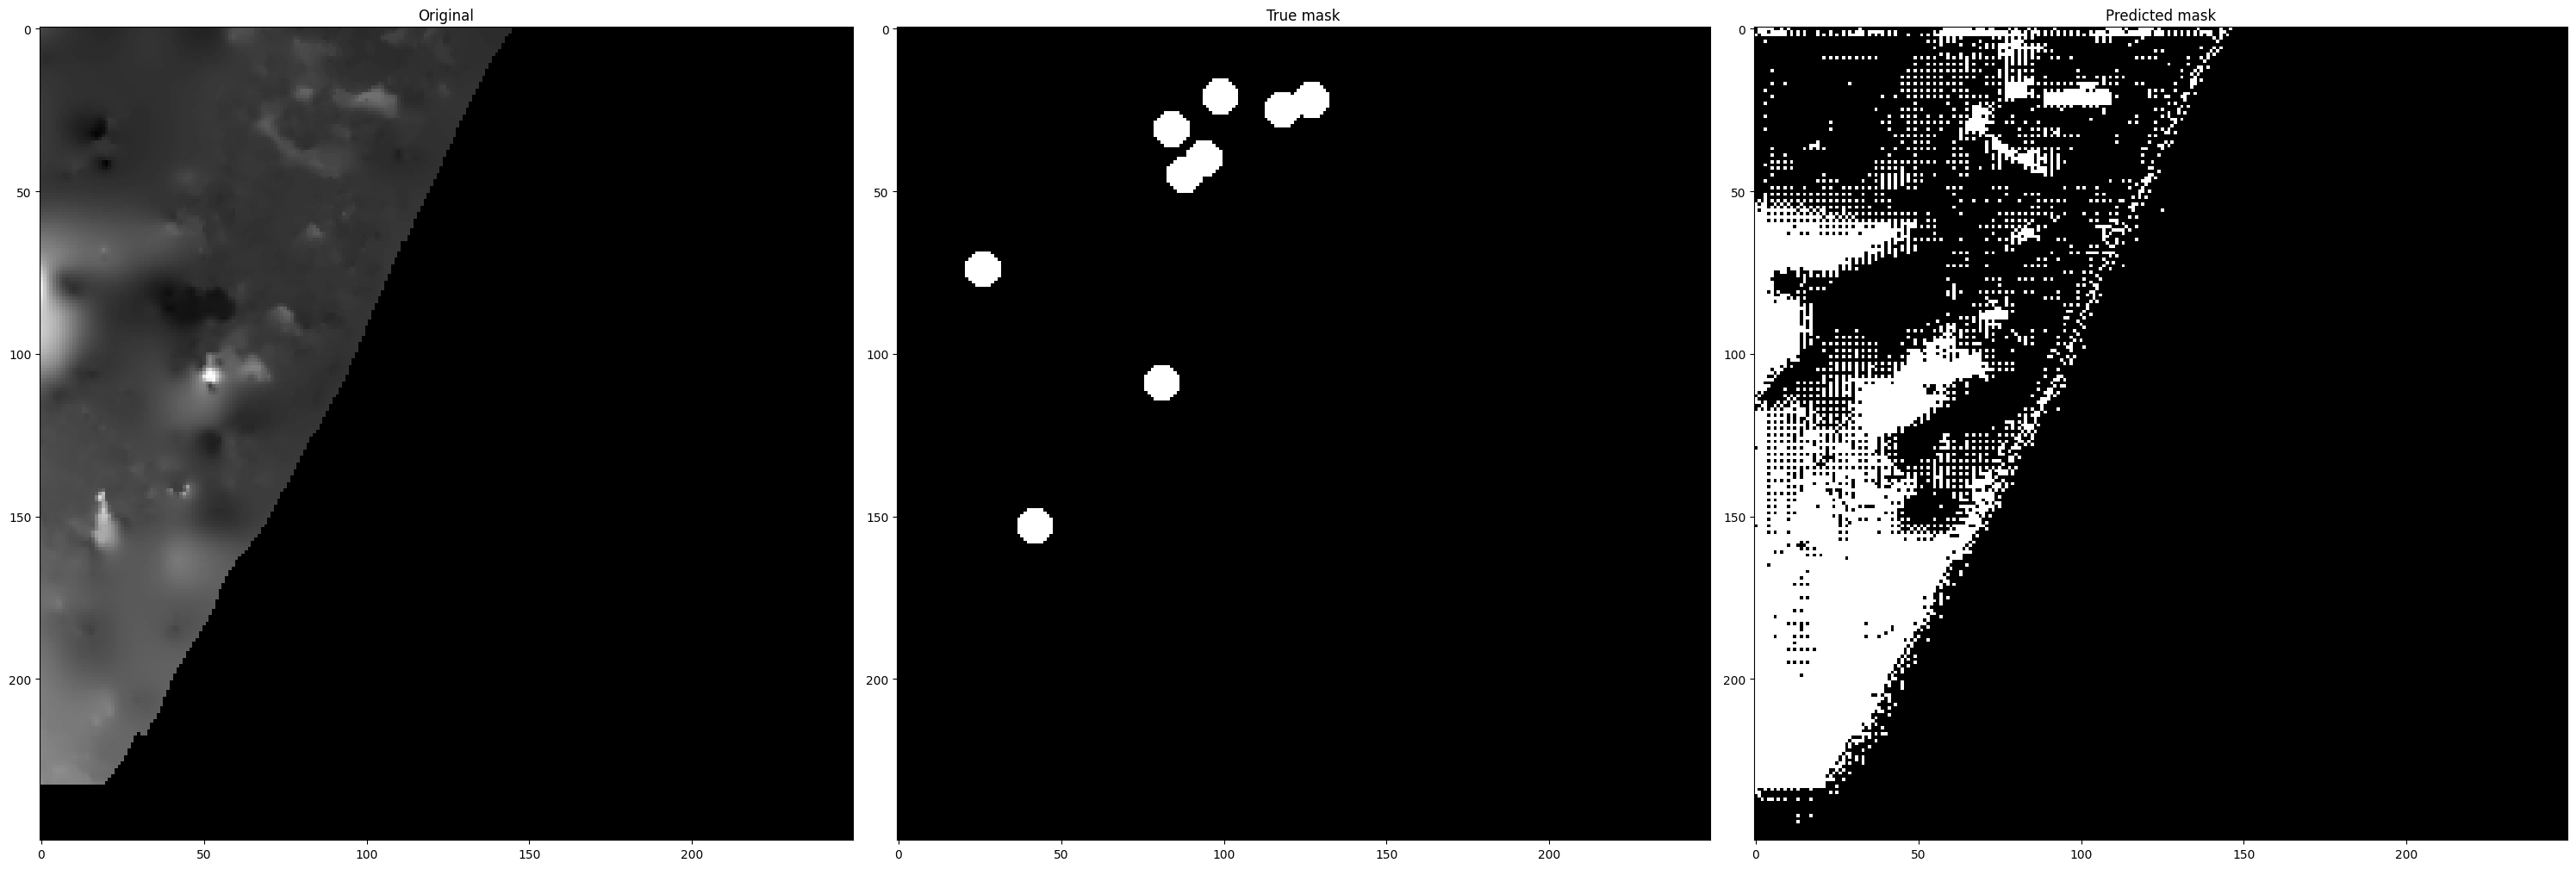

tile_tif_1_1.png


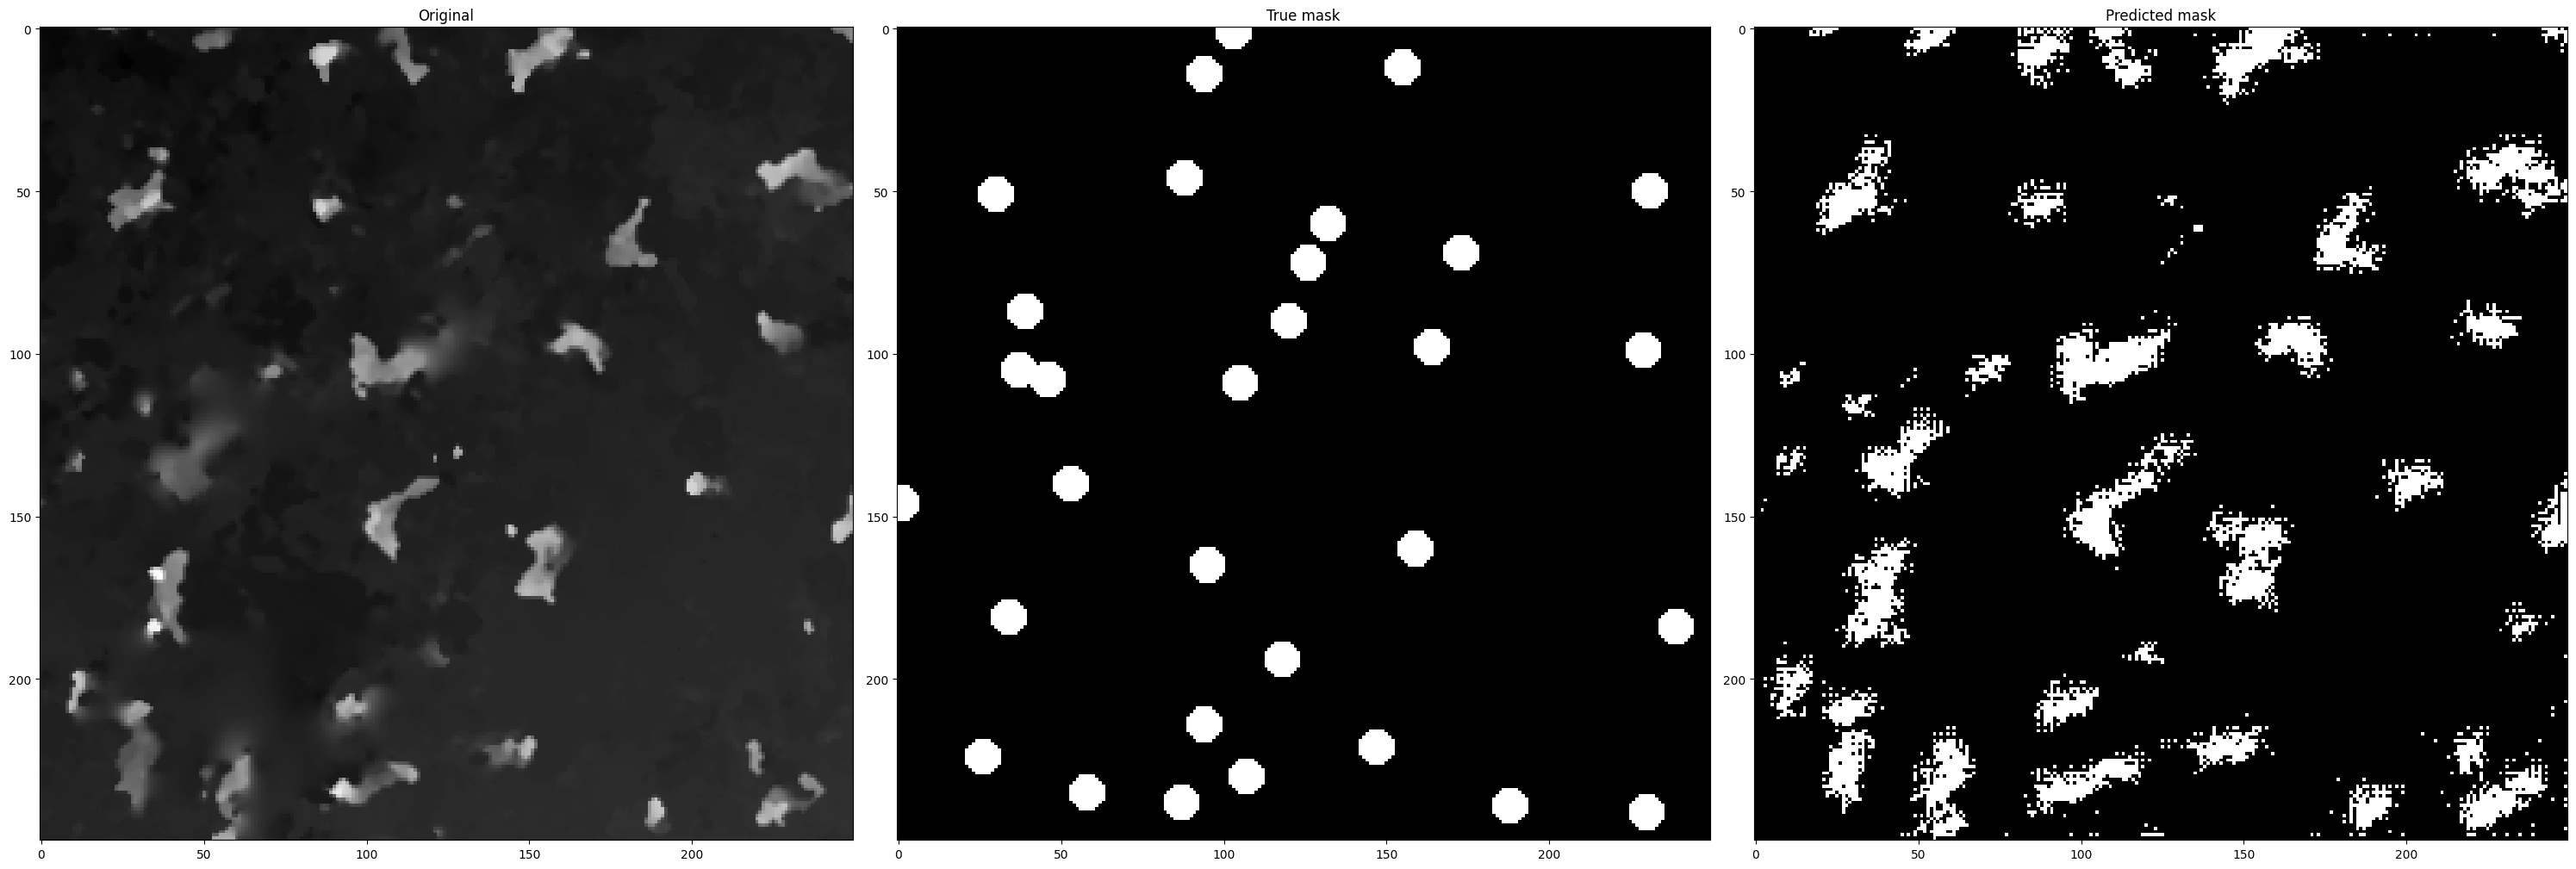

tile_tif_1_0.png


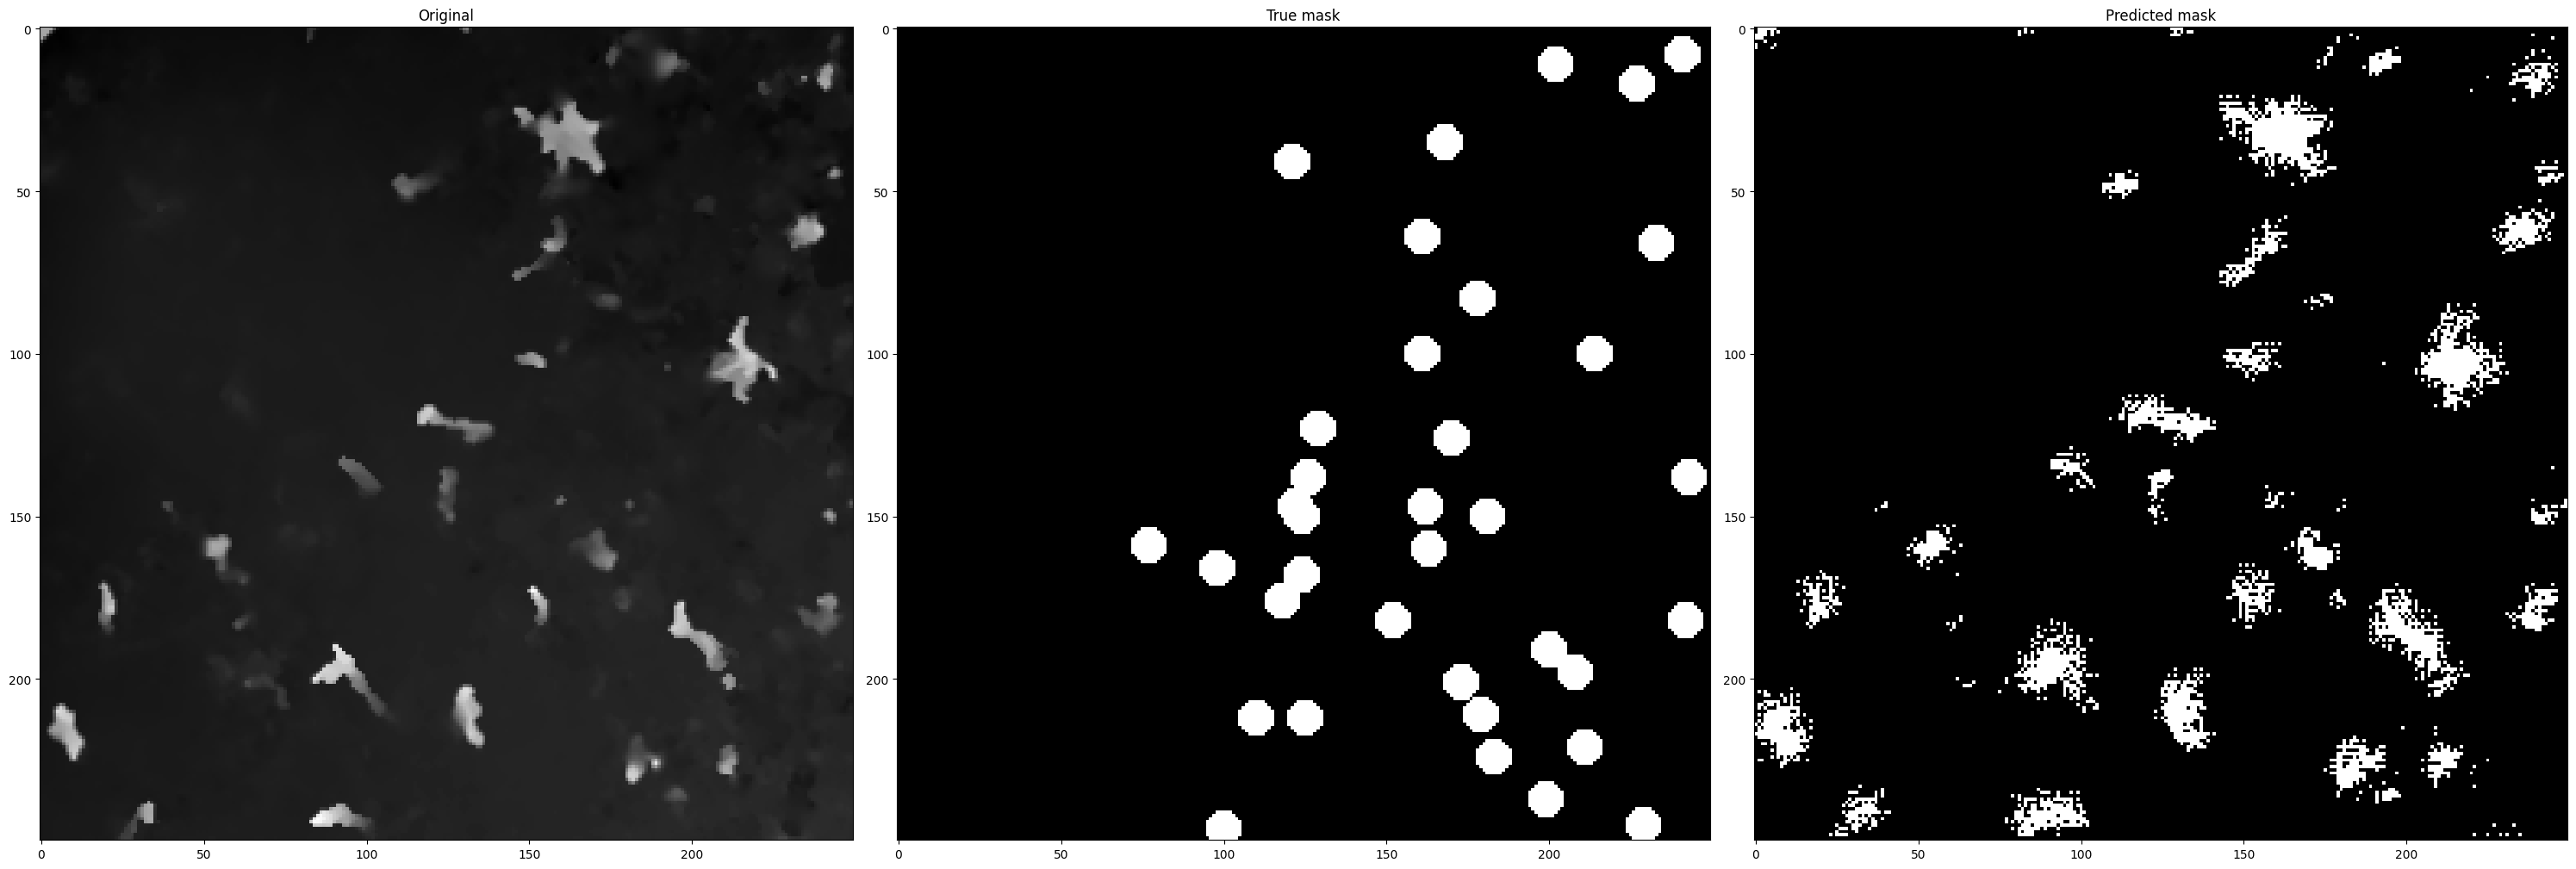

tile_tif_1_2.png


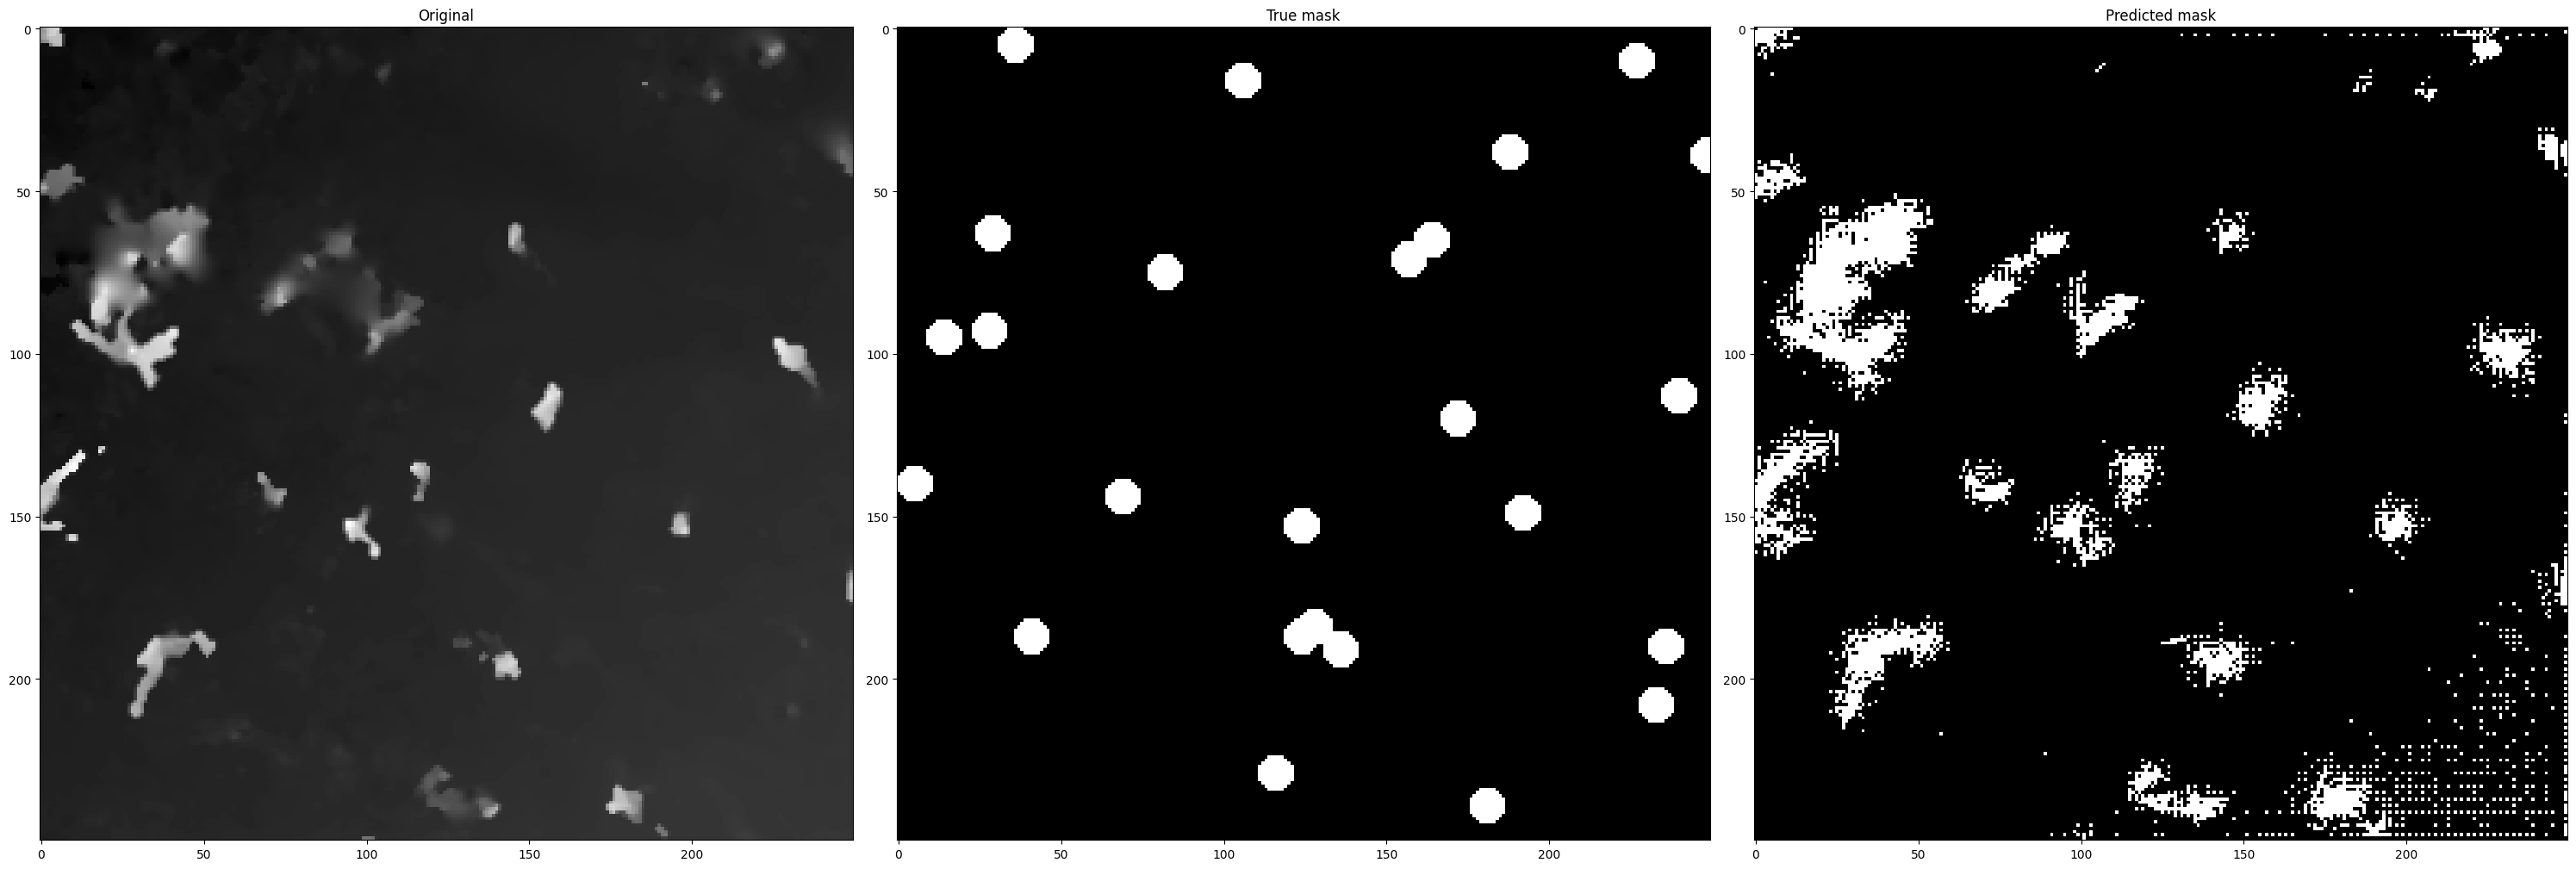

tile_tif_1_3.png


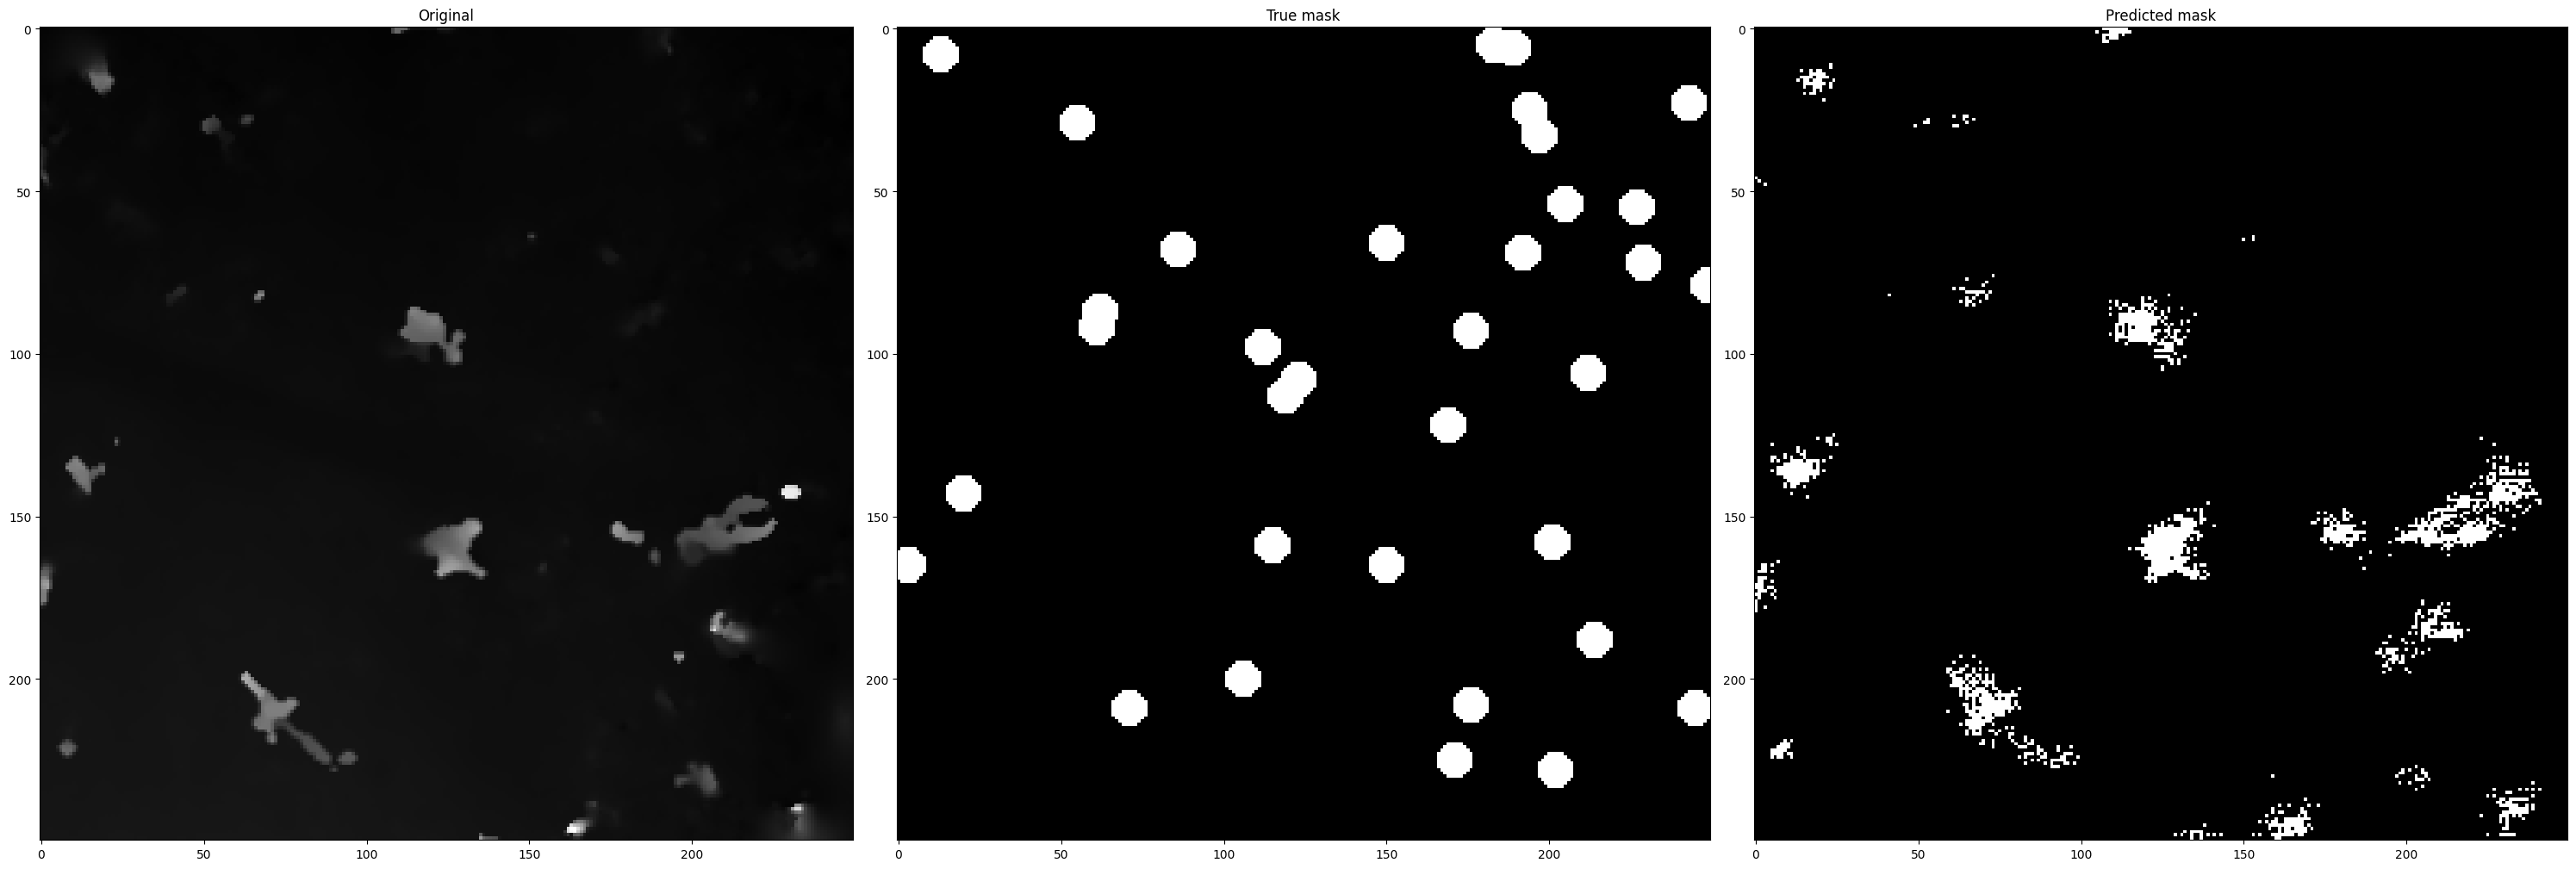

tile_tif_1_4.png


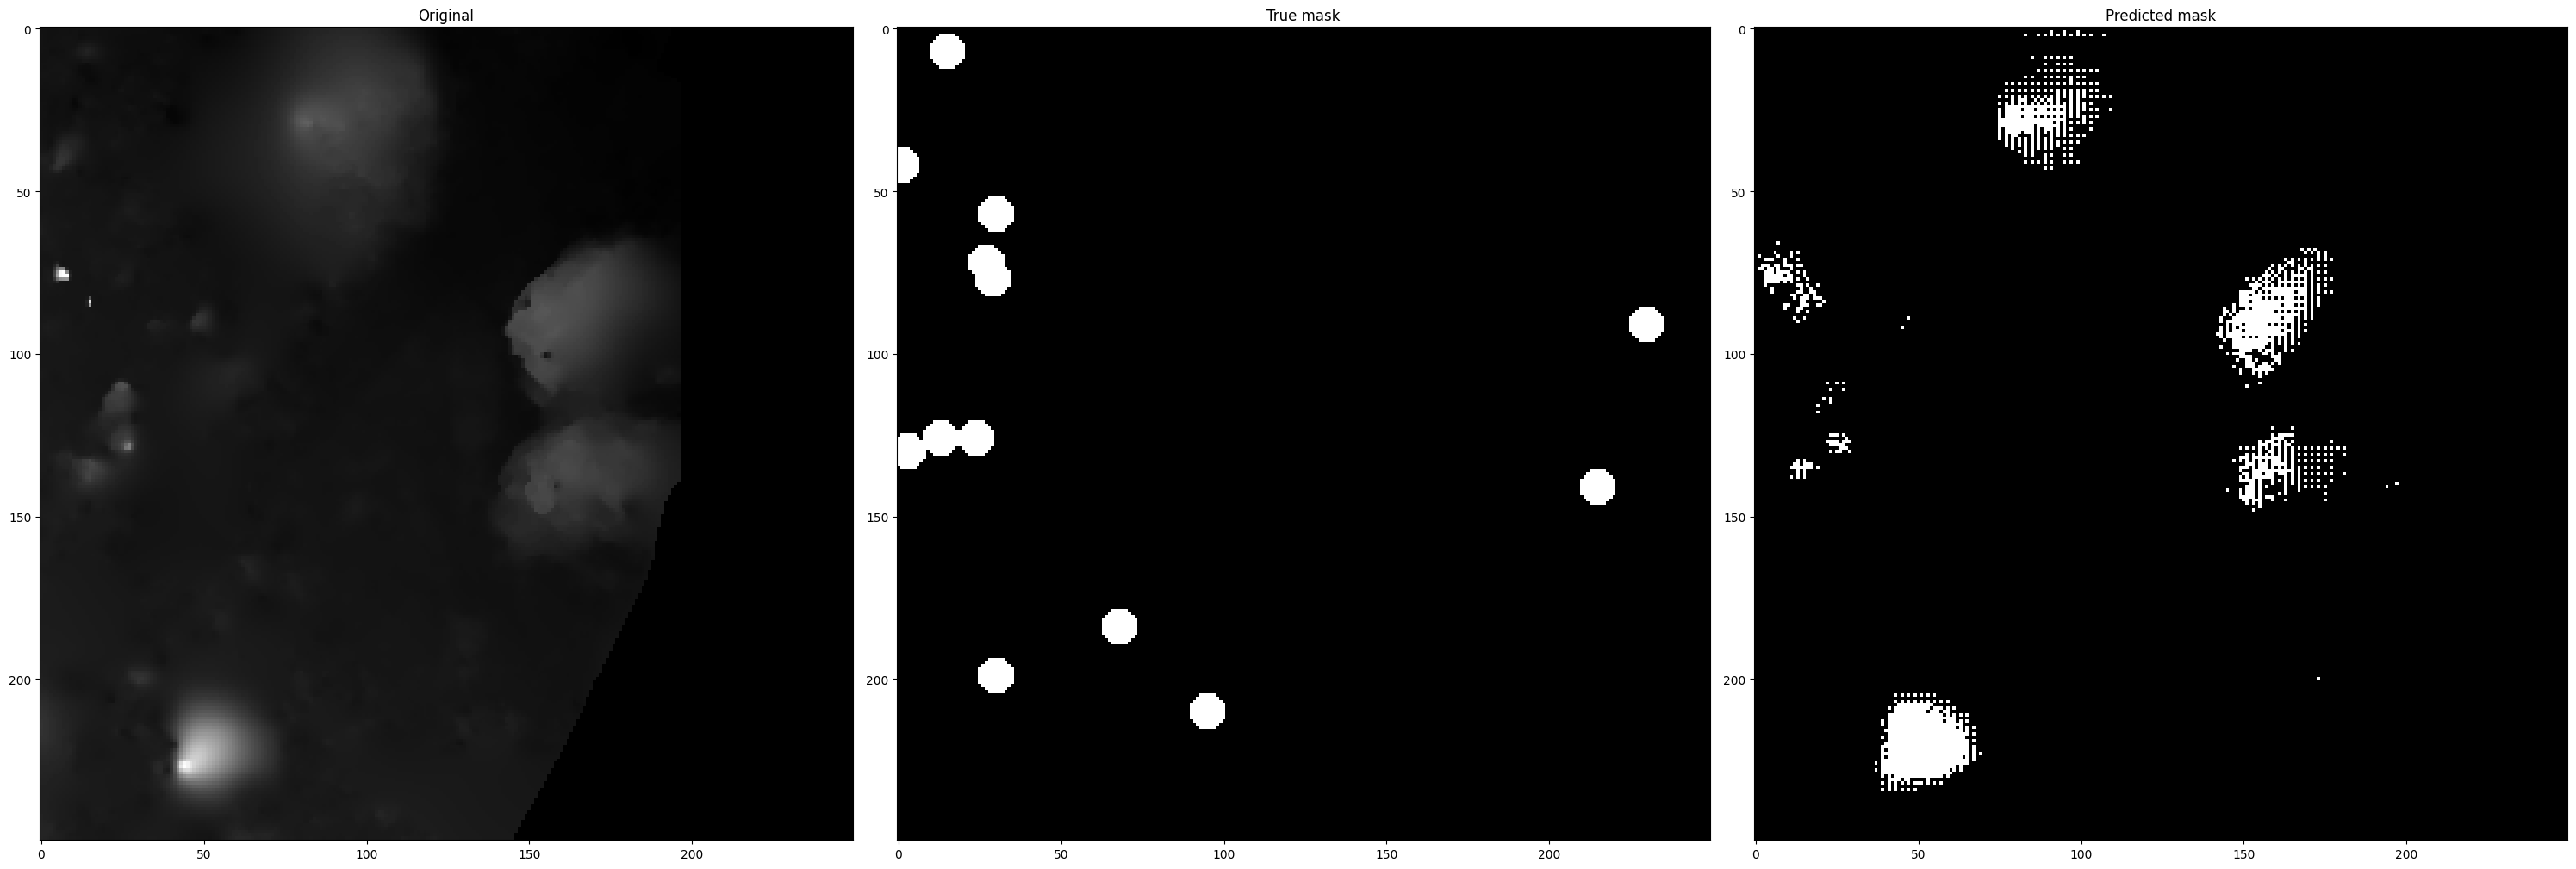

In [17]:
plot_prediction(net,
           '../data/tiles/formatted',
           '../results',
           out_threshold=0.6)

In [ ]:
convert_PNGtoSHP('../data/tiles/original')

In [63]:
image_coords = getPoints_fromPNG('../results/firstpred_2_4.png')
            
tif_path = '../data/tiles/original/tile_tif_2_4.tif'
with rasterio.open(tif_path) as src:
    transform = src.transform  #affine transformation object
    crs = src.crs  #coordinate Reference System
                
geo_coords = [transform * (x, y) for x, y in image_coords]
            
#geo_coords -> Points (obj.)
point_geoms = [Point(coord) for coord in geo_coords]
    
#create a GeoDataFrame with the Points
gdf = gpd.GeoDataFrame(geometry=point_geoms, crs=crs)  # Adjust CRS as needed
    
#save the GeoDataFrame as a shapefile
gdf.to_file('../results/firstpred_2_4.shp')